# Test for group differences in the Bayesian way

_Author: Christoph Rahmede_

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-the-data" data-toc-modified-id="Load-the-data-1">Load the data</a></span></li><li><span><a href="#Group-differences-and-frequentist-t-test" data-toc-modified-id="Group-differences-and-frequentist-t-test-2">Group differences and frequentist t-test</a></span></li><li><span><a href="#Differences-in-statistics-based-on-origin" data-toc-modified-id="Differences-in-statistics-based-on-origin-3">Differences in statistics based on origin</a></span><ul class="toc-item"><li><span><a href="#Trace-plot" data-toc-modified-id="Trace-plot-3.1">Trace plot</a></span></li><li><span><a href="#Vectorized-version" data-toc-modified-id="Vectorized-version-3.2">Vectorized version</a></span></li><li><span><a href="#Trace-plot" data-toc-modified-id="Trace-plot-3.3">Trace plot</a></span></li><li><span><a href="#Posterior-predictive-samples" data-toc-modified-id="Posterior-predictive-samples-3.4">Posterior predictive samples</a></span></li><li><span><a href="#Forest-plot" data-toc-modified-id="Forest-plot-3.5">Forest plot</a></span></li></ul></li><li><span><a href="#Modifying-the-model" data-toc-modified-id="Modifying-the-model-4">Modifying the model</a></span><ul class="toc-item"><li><span><a href="#Forest-plot" data-toc-modified-id="Forest-plot-4.1">Forest plot</a></span></li></ul></li><li><span><a href="#Differences-between-brands" data-toc-modified-id="Differences-between-brands-5">Differences between brands</a></span><ul class="toc-item"><li><span><a href="#Forest-plot" data-toc-modified-id="Forest-plot-5.1">Forest plot</a></span></li><li><span><a href="#Trace-plot" data-toc-modified-id="Trace-plot-5.2">Trace plot</a></span></li></ul></li><li><span><a href="#Hierarchical-model-of-origin-and-brands" data-toc-modified-id="Hierarchical-model-of-origin-and-brands-6">Hierarchical model of origin and brands</a></span><ul class="toc-item"><li><span><a href="#Forest-plot" data-toc-modified-id="Forest-plot-6.1">Forest plot</a></span></li><li><span><a href="#Trace-plot" data-toc-modified-id="Trace-plot-6.2">Trace plot</a></span></li><li><span><a href="#Model-summary" data-toc-modified-id="Model-summary-6.3">Model summary</a></span></li><li><span><a href="#Adjusted-means" data-toc-modified-id="Adjusted-means-6.4">Adjusted means</a></span></li></ul></li><li><span><a href="#Robust-model" data-toc-modified-id="Robust-model-7">Robust model</a></span><ul class="toc-item"><li><span><a href="#Forest-plot" data-toc-modified-id="Forest-plot-7.1">Forest plot</a></span></li><li><span><a href="#Summary" data-toc-modified-id="Summary-7.2">Summary</a></span></li></ul></li></ul></div>

Previously we looked at frequentist hypothesis tests like the t-test to assess the significance of observed differences in sample means. The result allowed us to accept or reject the null hypothesis of equal means. 

We can do something similar in a Bayesian context by determining the probability of a certain difference of means given the observed samples. We can develop MCMC models with much weaker assumptions and applicable to testing differences of arbitrary statistics.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5)

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
import pymc3 as pm
import arviz as az

## Load the data

We will work with the dataset we know already very well.

In [3]:
df = pd.read_csv(
    '/Users/maartenk/Documents/git/DsMasterClass/dataset-collection/auto-mpg/auto-mpg.csv', sep='\s+', header=None)
df.columns = ['mpg', 'cylinders', 'displacement', 'horsepower',
              'weight', 'acceleration', 'year', 'origin', 'name']
df.drop(df[df.horsepower == '?'].index, inplace=True)
df['horsepower'] = df.horsepower.astype(float)
df['brand'] = df.name.map(lambda x: x.split(' ')[0]
                          ).replace(
    {'toyouta': 'toyota',
     'maxda': 'mazda',
     'chevroelt': 'chevrolet',
     'vw': 'volkswagen',
     'vokswagen': 'volkswagen',
     'mercedes-benz': 'mercedes'})
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392 entries, 0 to 397
Data columns (total 10 columns):
mpg             392 non-null float64
cylinders       392 non-null int64
displacement    392 non-null float64
horsepower      392 non-null float64
weight          392 non-null float64
acceleration    392 non-null float64
year            392 non-null int64
origin          392 non-null int64
name            392 non-null object
brand           392 non-null object
dtypes: float64(5), int64(3), object(2)
memory usage: 33.7+ KB


In [4]:
df.head()

mpg  cylinders  displacement  horsepower  weight  acceleration  year  \
0  18.0          8         307.0       130.0  3504.0          12.0    70   
1  15.0          8         350.0       165.0  3693.0          11.5    70   
2  18.0          8         318.0       150.0  3436.0          11.0    70   
3  16.0          8         304.0       150.0  3433.0          12.0    70   
4  17.0          8         302.0       140.0  3449.0          10.5    70   

   origin                       name      brand  
0       1  chevrolet chevelle malibu  chevrolet  
1       1          buick skylark 320      buick  
2       1         plymouth satellite   plymouth  
3       1              amc rebel sst        amc  
4       1                ford torino       ford

## Group differences and frequentist t-test

We will be interested in differences between group means and standard deviations.

In [5]:
grouped_origin = df.groupby('origin')[['mpg']].agg([np.mean,np.std, lambda x: len(x)])
grouped_origin

mpg                   
             mean       std <lambda>
origin                              
1       20.033469  6.440384    245.0
2       27.602941  6.580182     68.0
3       30.450633  6.090048     79.0

As a reminder, we calculate the frequentist t-test results.

In [6]:
from scipy import stats
from itertools import combinations

In [7]:
for comb in combinations(df.origin.unique(), 2):
    t_test_result = stats.ttest_ind(
        df.mpg[df.origin == comb[0]], df.mpg[df.origin == comb[1]])
    print(comb, t_test_result.statistic, t_test_result.pvalue)

(1, 3) -12.664889006229084 4.17283714676552e-30
(1, 2) -8.534455914399228 6.306531719750568e-16
(3, 2) 2.723324735392516 0.007256875026960007


Create dummy variables for the origin:

In [8]:
df['american'] = df.origin.map(lambda x: 1 if x==1 else 0)
df['european'] = df.origin.map(lambda x: 1 if x==2 else 0)
df['asian'] = df.origin.map(lambda x: 1 if x==3 else 0)

Get the group observed values:

In [9]:
american_mpg = df.mpg[df.american==1]
european_mpg = df.mpg[df.european==1]
asian_mpg = df.mpg[df.asian==1]

As a reference, we obtain some statistics of the whole dataset. We will use those for formulating prior believes.

In [10]:
prior_mean = df.mpg.mean()
prior_std = df.mpg.std()
print(prior_mean, prior_std)

23.44591836734694 7.805007486571799


## Differences in statistics based on origin

We now set up a pymc3 model for determining the likely values for means and standard deviations in each group given the data.

As rather uninformed priors, we set up normal distributions centered on the mean of the whole group and with a standard deviation so large that we hardly limit the range of possible values. 

For the standard deviations of each group, we define an uninformed prior through a continuous uniform distribution between a very low and sufficiently high value. Since this distribution has support on a finite interval, any values outside that range will not be possible.

The likelihood function chosen as normal distributions for each group picks up the prior means and standard deviations of each group and the observed data per group.

We added deterministic distributions calculating differences of means and standard deviations for each pair of the groups for the values created in each sampling step. The individually sampled values are (pseudo-)random, but taking their differences does not add any further randomness. We could calculate these differences as well from the trace results. The benefit of defining these additional distributions is that they are directly stored in the trace.

In [11]:
prior_mean_std = 50
prior_std_lower = 0.00001
prior_std_upper = 10.

In [12]:
with pm.Model() as model:
    
    #priors
    
    am_mean = pm.Normal('american_mean', prior_mean, sd=prior_mean_std)
    eu_mean = pm.Normal('european_mean', prior_mean, sd=prior_mean_std)
    as_mean = pm.Normal('asian_mean', prior_mean, sd=prior_mean_std)
    
    am_std = pm.Uniform('american_std', lower=prior_std_lower,upper=prior_std_upper)
    eu_std = pm.Uniform('european_std',lower=prior_std_lower,upper=prior_std_upper)
    as_std = pm.Uniform('asian_std',lower=prior_std_lower,upper=prior_std_upper)
    
    # likelihood
    
    am_mpg = pm.Normal('american_mpg', mu=am_mean, sd=am_std, observed=american_mpg)
    eu_mpg = pm.Normal('european_mpg', mu=eu_mean, sd=eu_std, observed=european_mpg)
    as_mpg = pm.Normal('asian_mpg', mu=as_mean, sd=as_std, observed=asian_mpg)
    
    # deterministic 
    
    delta_mean_am_eu = pm.Deterministic('delta_mean_am_eu', am_mean - eu_mean)
    delta_std_am_eu = pm.Deterministic('delta_std_am_eu', am_std - eu_std)
    
    delta_mean_am_as = pm.Deterministic('delta_mean_am_as', am_mean - as_mean)
    delta_std_am_as = pm.Deterministic('delta_std_am_as', am_std - as_std)
    
    delta_mean_eu_as = pm.Deterministic('delta_mean_eu_as', eu_mean-as_mean)
    delta_std_eu_as = pm.Deterministic('delta_std_euro_as', eu_std-as_std)

In [13]:
model.model

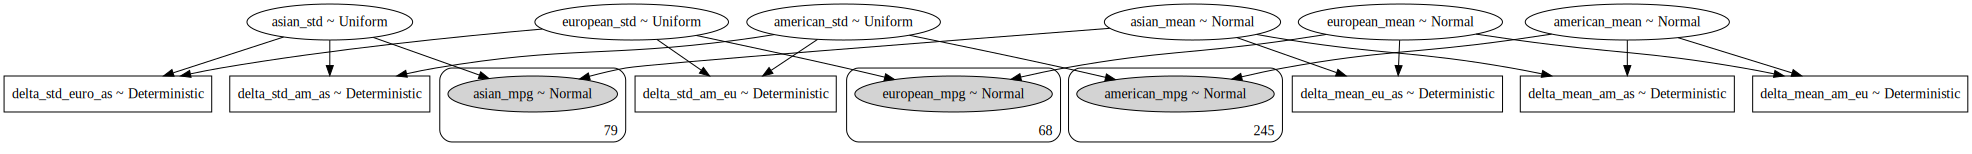

In [14]:
pm.model_to_graphviz(model)

In [16]:
with model:
    trace = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [asian_std, european_std, american_std, asian_mean, european_mean, american_mean]
Sampling 4 chains: 100%|██████████| 22000/22000 [00:11<00:00, 1963.57draws/s]


### Trace plot

In [17]:
trace.varnames

['american_mean',
 'european_mean',
 'asian_mean',
 'american_std_interval__',
 'european_std_interval__',
 'asian_std_interval__',
 'american_std',
 'european_std',
 'asian_std',
 'delta_mean_am_eu',
 'delta_std_am_eu',
 'delta_mean_am_as',
 'delta_std_am_as',
 'delta_mean_eu_as',
 'delta_std_euro_as']

In [18]:
[name for name in trace.varnames if 'delta' not in name if '__' not in name]

['american_mean',
 'european_mean',
 'asian_mean',
 'american_std',
 'european_std',
 'asian_std']

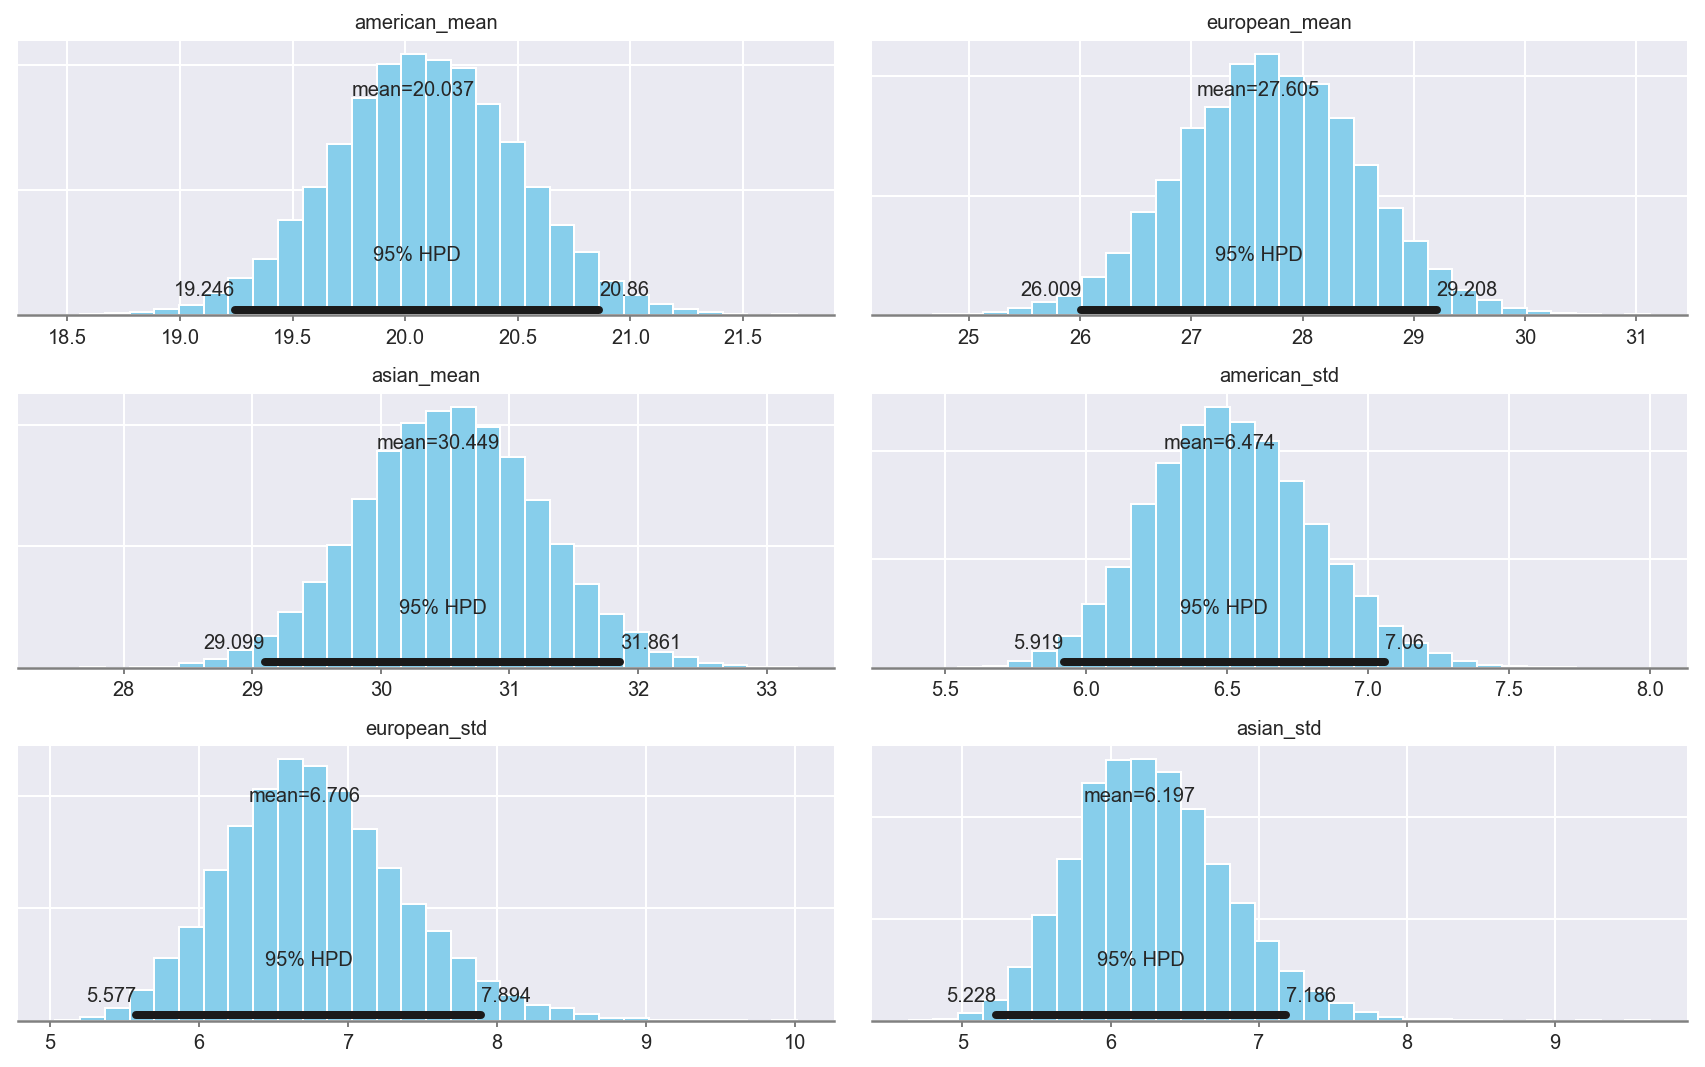

In [19]:
pm.plot_posterior(trace,varnames=[name for name in trace.varnames if 'delta' not in name if '__' not in name])    
plt.show()

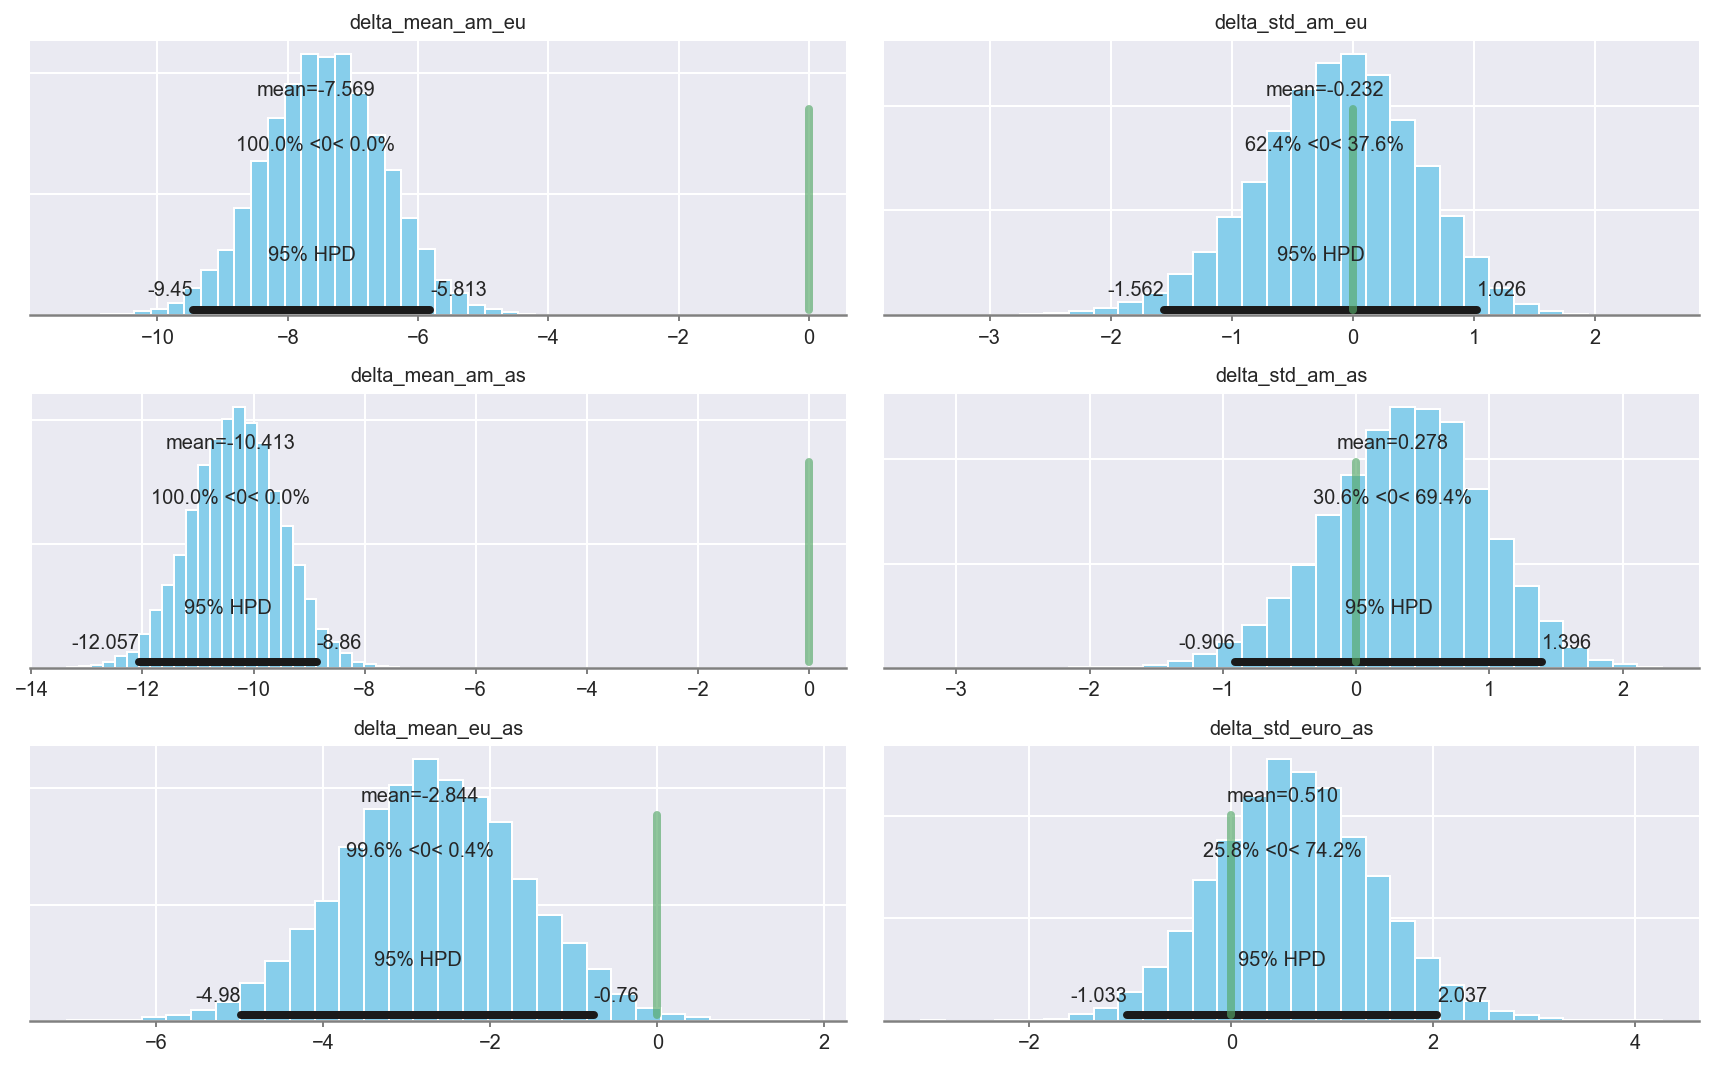

In [20]:
pm.plot_posterior(trace,varnames=[name for name in trace.varnames if 'delta' in name], ref_val=0)    
plt.show()

### Vectorized version

We wrote all the parts explicitly above, but that would be unfeasible for larger numbers of groups and comparisons. Therefore we rather vectorize the formulation of the model.

In [21]:
mpg_values = [american_mpg.values, european_mpg.values, asian_mpg.values]

In [22]:
from itertools import combinations

In [23]:
list(combinations(range(3),2))

[(0, 1), (0, 2), (1, 2)]

In [24]:
n_groups = 3

In [25]:
with pm.Model() as model_v:
    
    mean = pm.Normal('mean', prior_mean, sd=prior_mean_std, shape=n_groups)
    std = pm.Uniform('std', lower=prior_std_lower,upper=prior_std_upper, shape=n_groups)
    
    mpg = {}
    
    for i, observed in enumerate(mpg_values):
        mpg[i] = pm.Normal('{}'.format(i), mu=mean[i], sd=std[i], observed=mpg_values[i])

    mean_delta = {}
    std_delta = {}
    
    for i,j in combinations(range(n_groups),2):
        mean_delta[(i,j)] = pm.Deterministic('delta_mean_{}'.format((i,j)), mean[i]-mean[j])
        std_delta[(i,j)] = pm.Deterministic('delta_std_{}'.format((i,j)), std[i]-std[j])

In [26]:
with model_v:
    trace_v = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [std, mean]
Sampling 4 chains: 100%|██████████| 22000/22000 [00:13<00:00, 1608.98draws/s]


### Trace plot

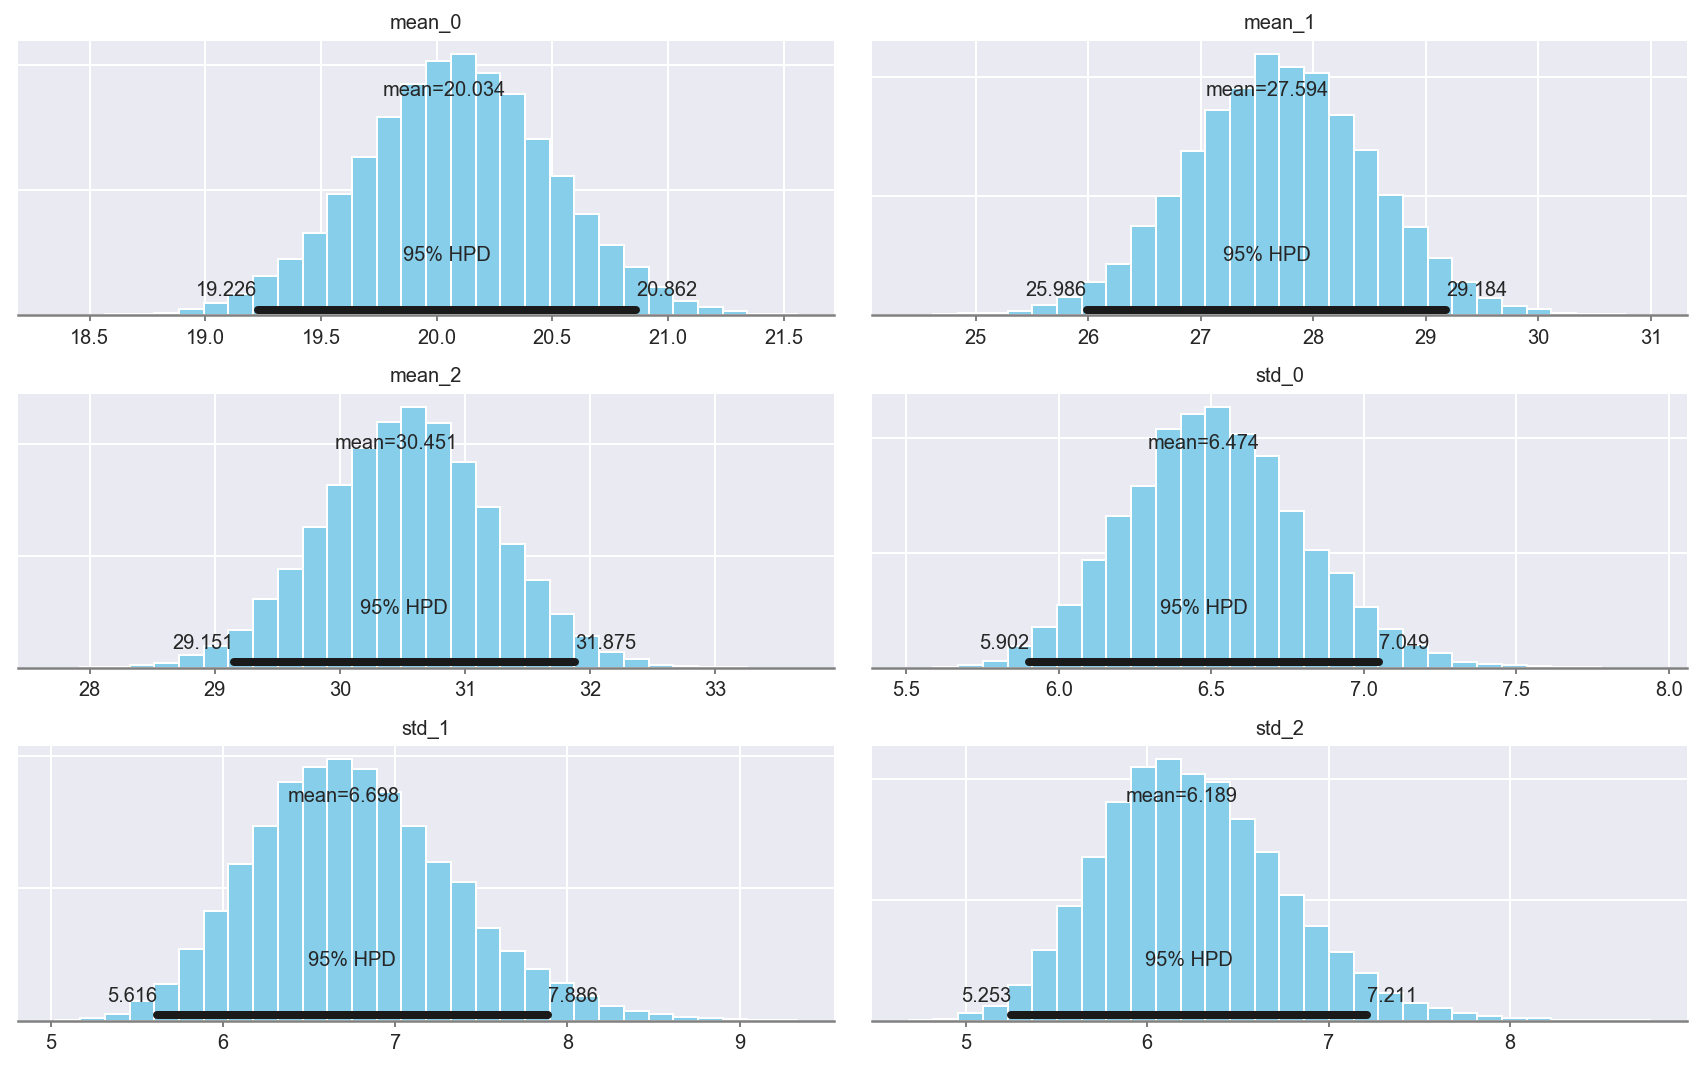

In [27]:
pm.plot_posterior(trace_v, varnames=['mean','std'])    
plt.show()

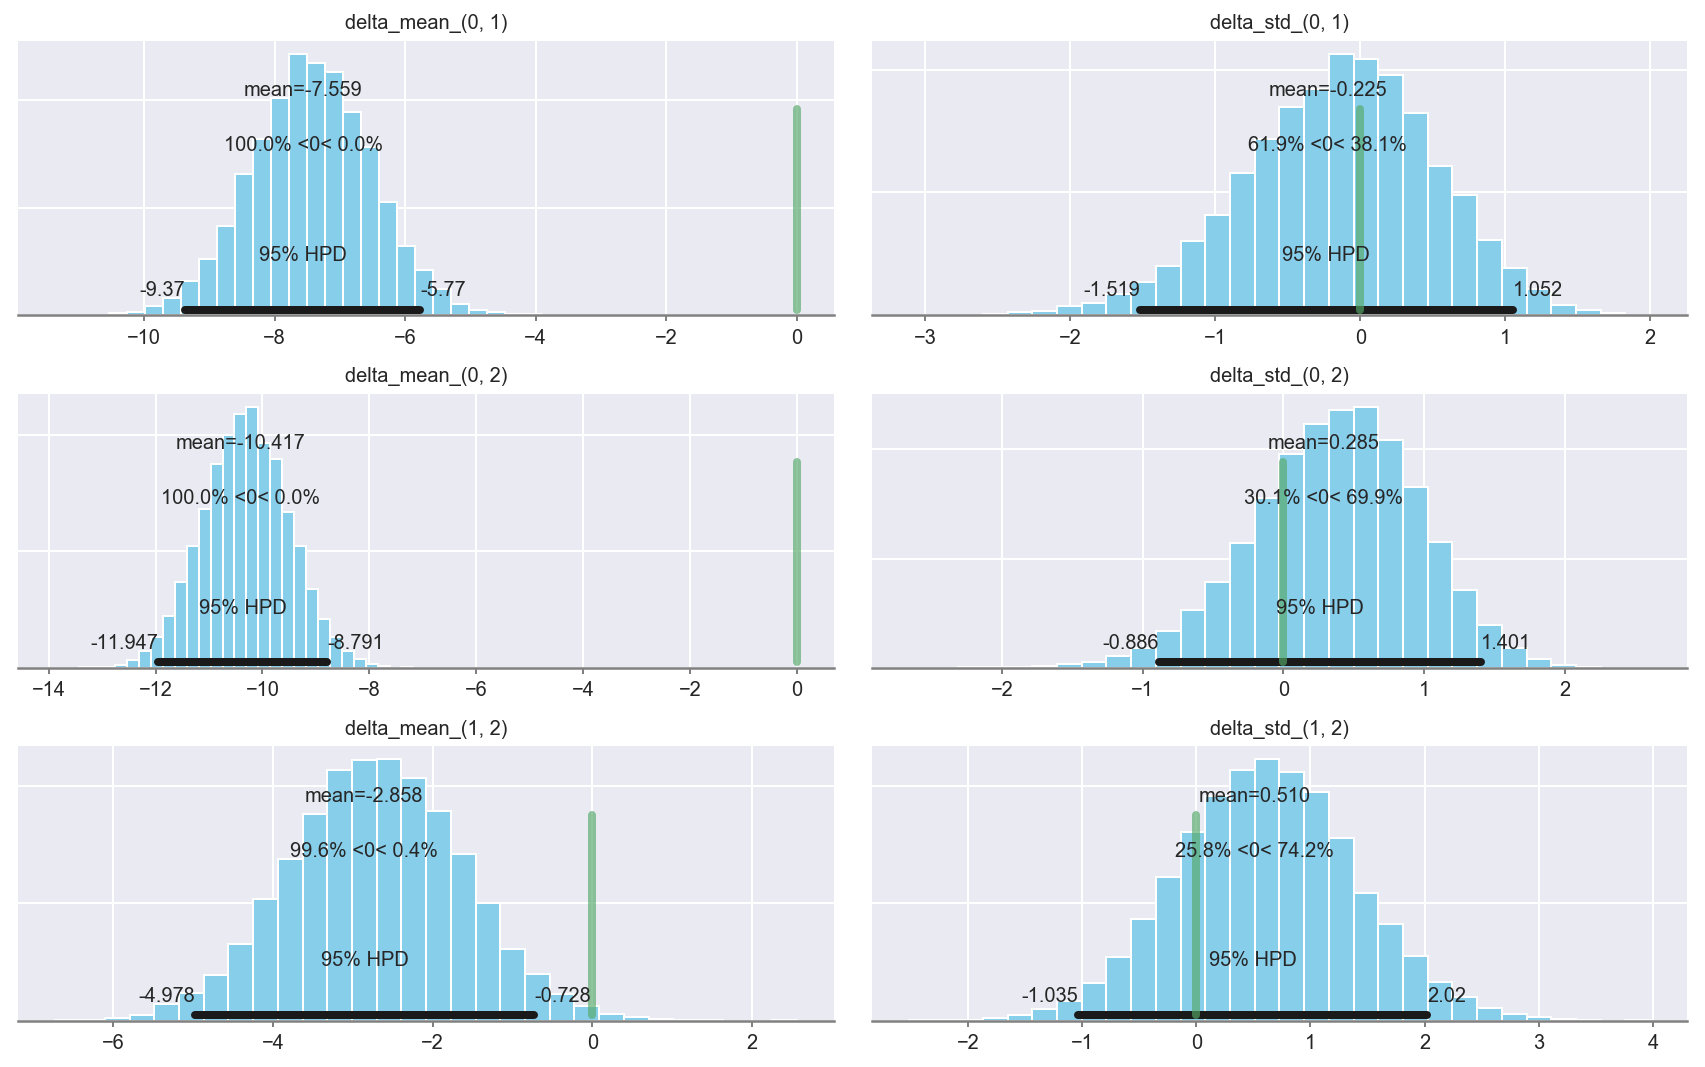

In [28]:
pm.plot_posterior(trace_v, varnames=[name for name in trace_v.varnames if 'delta' in name],ref_val=0)    
plt.show()

### Posterior predictive samples

We can sample from the posterior to obtain predictions for the distribution of the group means. Arviz is useful for that purpose.

In [29]:
posterior_predictive = pm.sample_posterior_predictive(trace_v,samples=100,model=model_v)

100%|██████████| 100/100 [00:01<00:00, 79.21it/s]


In [30]:
az_data = az.from_pymc3(trace=trace_v,posterior_predictive=posterior_predictive)

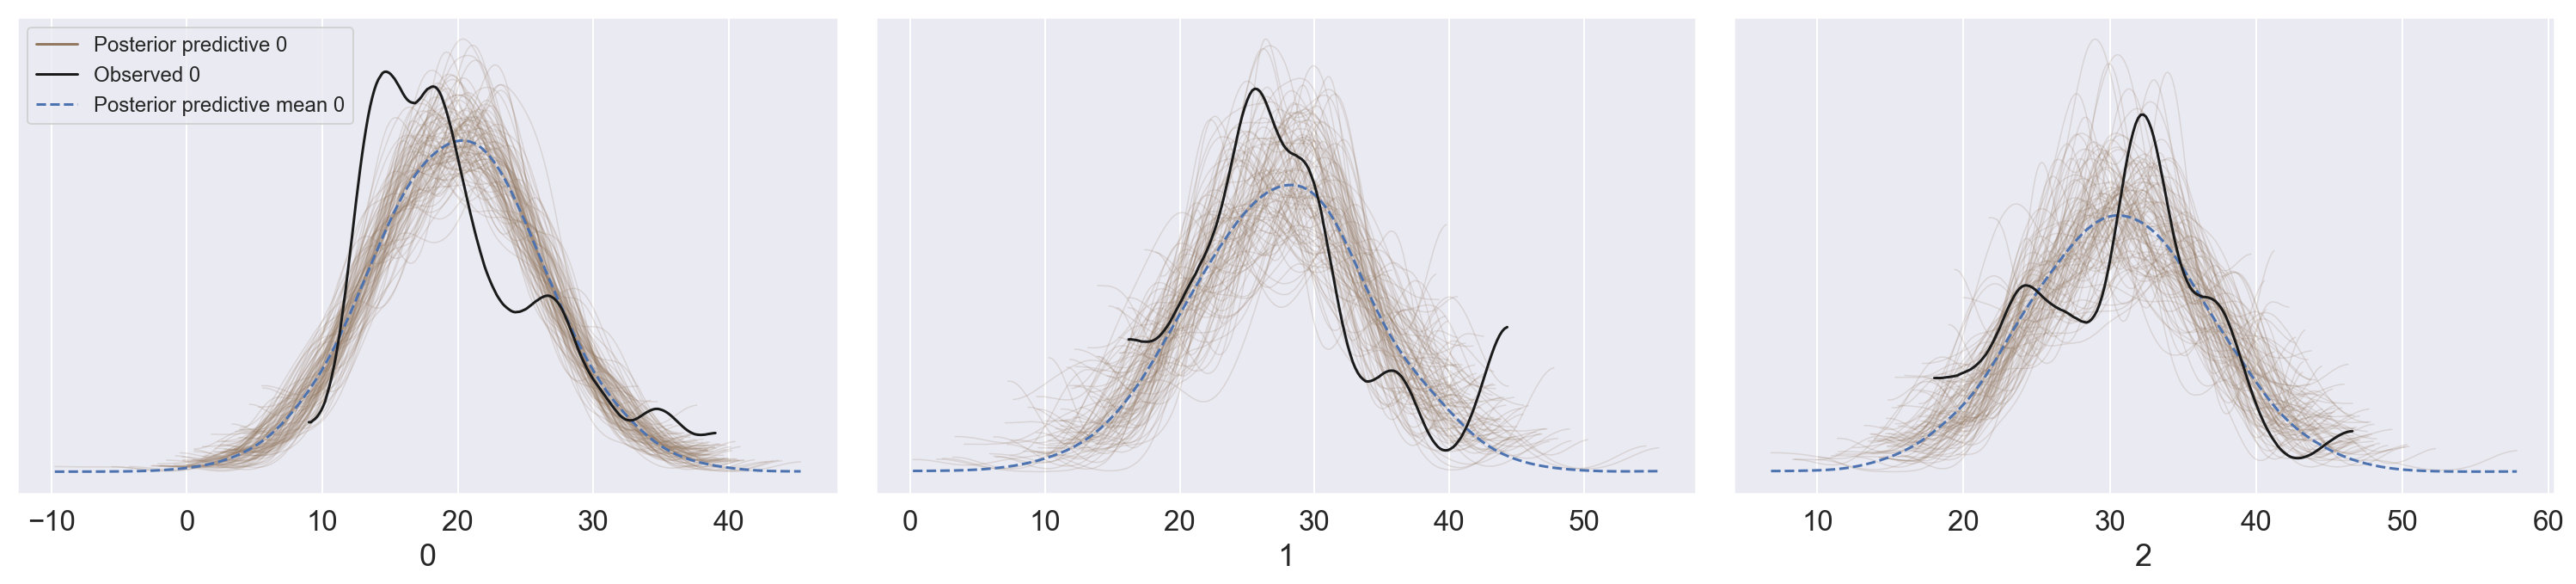

In [31]:
ax = az.plot_ppc(az_data, kind='density')
ax[0].legend(loc='upper left', fontsize=12)
ax[1].get_legend().remove()
ax[2].get_legend().remove()
plt.show()

### Forest plot

Since we have now quite many variables in the trace, a forest plot can give a useful quick visualization of the results.

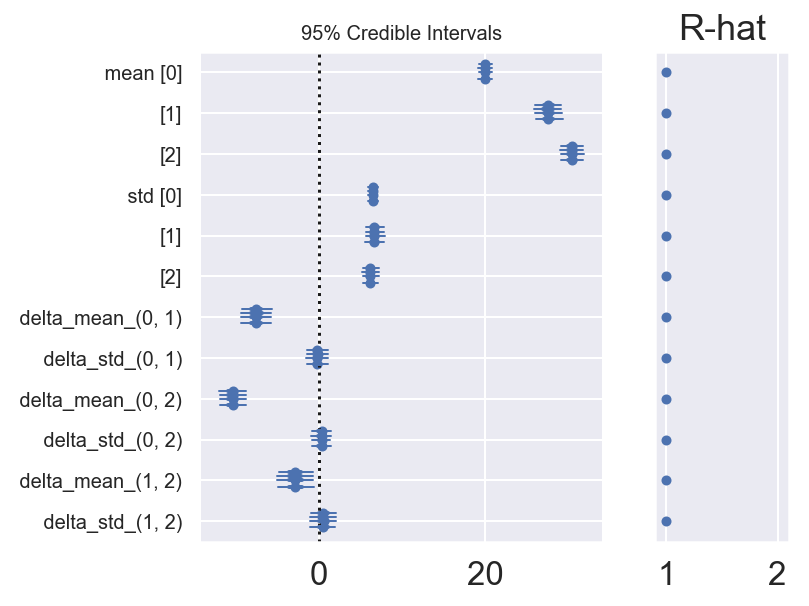

In [32]:
pm.forestplot(trace_v)
plt.show()

## Modifying the model

We can modify the model in various ways. 

- First we can change the prior for the standard deviation to a Gamma distribution which has the advantage of having support on all positive numbers.

- Second we can use a more robust distribution for the likelihood like the t-distribution. This brings an additional parameter $\nu$. For large values of $\nu$ we get a normal distribution, for small values the distribution becomes however broader. We choose priors in such a way that small values become likelier through an exponential distribution, but limit also to having values greater than one for the appropriate values of the t-distribution.

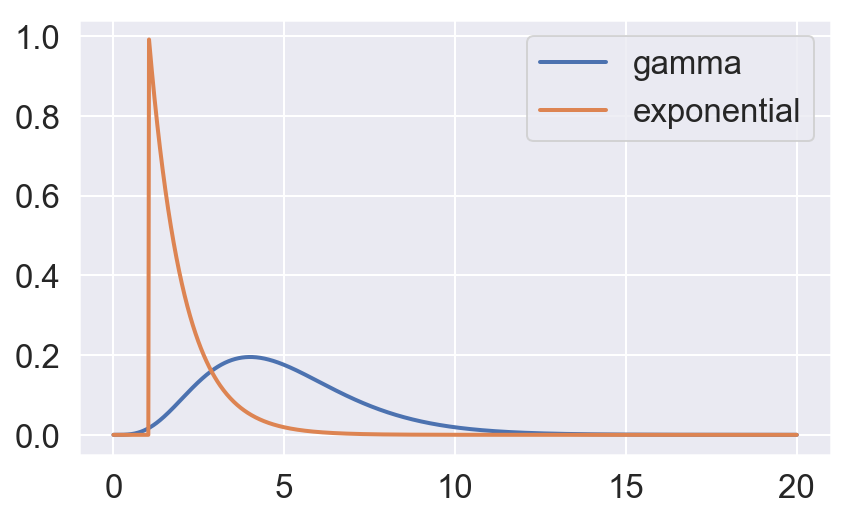

In [33]:
xvals = np.linspace(0,20,1000)
gamma_dist = stats.gamma(5)
yvals = gamma_dist.pdf(xvals)
exp_dist = stats.expon(1/30+1)
yvals = gamma_dist.pdf(xvals)
yvals_e = exp_dist.pdf(xvals)
plt.plot(xvals,yvals, lw=2, label='gamma')
plt.plot(xvals,yvals_e, lw=2, label='exponential')
plt.legend()
plt.show()

In [34]:
with pm.Model() as model_v1:
    
    mean = pm.Normal('mean', mu=prior_mean, sd=prior_mean_std, shape=n_groups)
    std = pm.Gamma('std', mu=5, sd=10, shape=n_groups)
    nu_minus1 = pm.Exponential('nu_minus1', 1/29)
    nu = pm.Deterministic('nu', nu_minus1+1)
    
    mpg = {}
    
    for i, observed in enumerate(mpg_values):
        mpg[i] = pm.StudentT('{}'.format(i), nu=nu, mu=mean[i], sd=std[i], observed=mpg_values[i])

    mean_delta = {}
    std_delta = {}
    
    for i,j in combinations(range(n_groups),2):
        mean_delta[(i,j)] = pm.Deterministic('delta_mean_{}'.format((i,j)), mean[i]-mean[j])
        std_delta[(i,j)] = pm.Deterministic('delta_std_{}'.format((i,j)), std[i]-std[j])

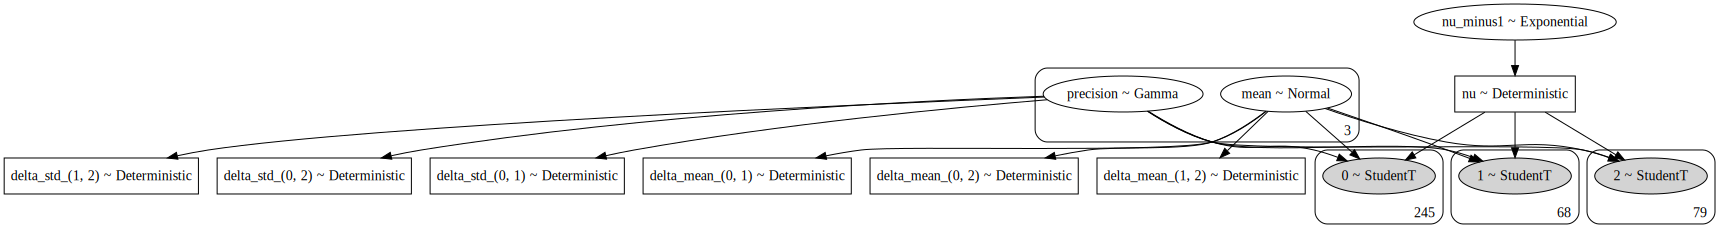

In [36]:
pm.model_to_graphviz(model_v1)

In [35]:
with model_v1:
    trace_v1 = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu_minus1, precision, mean]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:04<00:00, 672.16draws/s]


### Forest plot

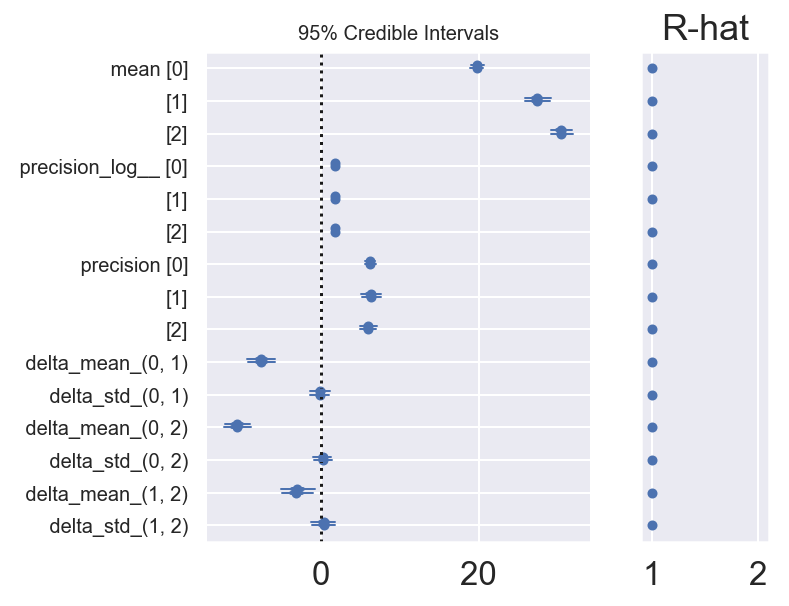

In [36]:
pm.forestplot(trace_v1, varnames=[name for name in trace_v1.varnames if 'nu' not in name])
plt.show()

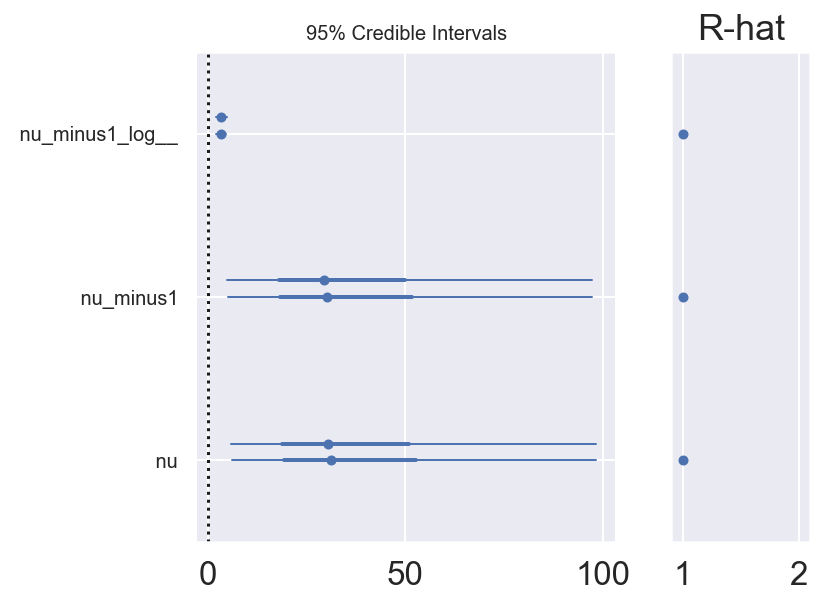

In [37]:
pm.forestplot(trace_v1, varnames=[name for name in trace_v1.varnames if 'nu' in name])
plt.show()

## Differences between brands

We took so far only the origin into account. We could build a hierarchical model taking also the individual brand statistics into account.


In [38]:
grouped_brands = df.groupby('brand')[['horsepower']].agg([np.mean,np.std])
grouped_brands

horsepower           
                  mean        std
brand                            
amc         114.703704  29.431557
audi         86.714286  11.842217
bmw         111.500000   2.121320
buick       136.411765  45.098585
cadillac    152.500000  38.890873
capri        92.000000        NaN
chevrolet   112.750000  35.435579
chevy       142.333333  59.045180
chrysler    153.666667  54.650404
datsun       83.826087  19.253458
dodge       117.178571  37.724198
fiat         73.375000  12.546343
ford        112.229167  37.139323
hi          193.000000        NaN
honda        67.846154  11.312575
mazda        77.666667  17.452967
mercedes     88.000000  28.160256
mercury     119.818182  48.157696
nissan       88.000000        NaN
oldsmobile  122.000000  37.357135
opel         81.000000   6.480741
peugeot      88.000000  19.654153
plymouth    111.419355  37.713635
pontiac     136.937500  51.815659
renault      70.000000  12.529964
saab        108.750000   9.464847
subaru       73.500000  13.000000
toyota       83.961538  18.173565
triumph      88.000000        NaN
volkswagen   64.136364  11.622210
volvo       104.166667  16.690317

In [39]:
brands = grouped_brands.dropna().index

In [40]:
brands

Index(['amc', 'audi', 'bmw', 'buick', 'cadillac', 'chevrolet', 'chevy',
       'chrysler', 'datsun', 'dodge', 'fiat', 'ford', 'honda', 'mazda',
       'mercedes', 'mercury', 'oldsmobile', 'opel', 'peugeot', 'plymouth',
       'pontiac', 'renault', 'saab', 'subaru', 'toyota', 'volkswagen',
       'volvo'],
      dtype='object', name='brand')

In [41]:
len(brands)

27

First we model only the brands.

In [42]:
with pm.Model() as model_b:
    
    
    mean = pm.Normal('mean', prior_mean, sd=prior_std, shape=len(brands))
    std = pm.Uniform('std', lower=prior_std_lower,upper=prior_std_upper, shape=len(brands))

    mpg = {}
    for i, brand in enumerate(brands):
        mpg[i] = pm.Normal('{}'.format(i), mu=mean[i], sd=std[i], observed=df.mpg[df.brand==brand].values)

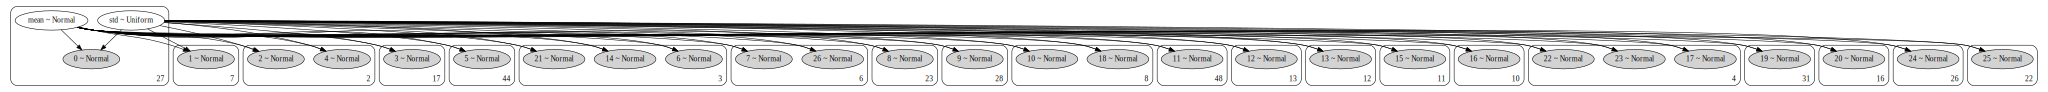

In [43]:
pm.model_to_graphviz(model_b)

In [44]:
with model_b:
    trace_b = pm.sample(5000, njobs=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [std, mean]
Sampling 2 chains: 100%|██████████| 11000/11000 [01:06<00:00, 165.82draws/s]
The number of effective samples is smaller than 25% for some parameters.


In [45]:
trace_b[0]

{'mean': array([18.444742  , 25.21104114, 14.31473223, 18.85159868, 18.81930793,
        20.94528564, 19.19293326, 18.09303473, 30.99146159, 22.78099578,
        30.16464275, 19.81339679, 34.23473213, 29.50831424, 25.92646528,
        19.47565425, 18.12833063, 29.1001433 , 22.19710139, 19.83189648,
        18.52771808, 29.02117974, 23.65938872, 28.58739405, 27.95962488,
        31.58476498, 23.29022335]),
 'std_interval__': array([-0.66083212,  1.78146945,  0.97520278,  0.33917384, -0.41854799,
         0.33166728,  1.64831065,  0.41716262,  0.25670784,  0.79664264,
        -0.29901895,  0.75680326, -0.0124752 ,  2.77016608,  0.87059844,
         0.16496307,  2.14578618, -0.9821498 , -0.15142038,  1.03480803,
         1.69665285,  0.04471025, -2.0031332 , -0.32495715,  0.00278135,
         0.47876149, -0.7453545 ]),
 'std': array([3.40553371, 8.55878363, 7.2615558 , 5.8399024 , 3.96864858,
        5.82165414, 8.3866276 , 6.02804488, 5.63827271, 6.89256163,
        4.25797902, 6.8065960

In [46]:
pm.summary(trace)

mean        sd  mc_error    hpd_2.5   hpd_97.5  \
american_mean      20.028698  0.411748  0.003622  19.198886  20.799709   
european_mean      27.582581  0.807553  0.008786  25.953857  29.086930   
asian_mean         30.455694  0.708189  0.007029  29.071931  31.857411   
american_std        6.469251  0.289992  0.002704   5.884146   7.017653   
european_std        6.699378  0.581986  0.006990   5.598435   7.845358   
asian_std           6.193659  0.514358  0.005716   5.218851   7.224902   
delta_mean_am_eu   -7.553882  0.912059  0.009472  -9.287220  -5.758300   
delta_std_am_eu    -0.230127  0.653412  0.007661  -1.504016   1.031309   
delta_mean_am_as  -10.426995  0.809442  0.008217 -11.973999  -8.823576   
delta_std_am_as     0.275592  0.587848  0.006293  -0.901403   1.390162   
delta_mean_eu_as   -2.873113  1.085528  0.011839  -4.875743  -0.618083   
delta_std_euro_as   0.505719  0.776649  0.009359  -1.031656   2.002566   

                          n_eff      Rhat  
american_mean      12849.128373  1.000169  
european_mean       9145.247849  0.999969  
asian_mean         10969.989445  0.999903  
american_std       10782.485055  1.000081  
european_std        7392.928265  1.000211  
asian_std           8549.094602  0.999937  
delta_mean_am_eu    9642.234261  0.999900  
delta_std_am_eu     7703.502783  1.000370  
delta_mean_am_as   11373.275947  0.999946  
delta_std_am_as     9053.067512  1.000043  
delta_mean_eu_as    9770.657771  0.999925  
delta_std_euro_as   8116.674866  0.999984

### Forest plot

We can easily visualize which brands are within rope boundaries of the whole dataset's mean.

In [47]:
rope_boundaries = np.around(df.mpg.mean()+np.array([-1,1]),2)

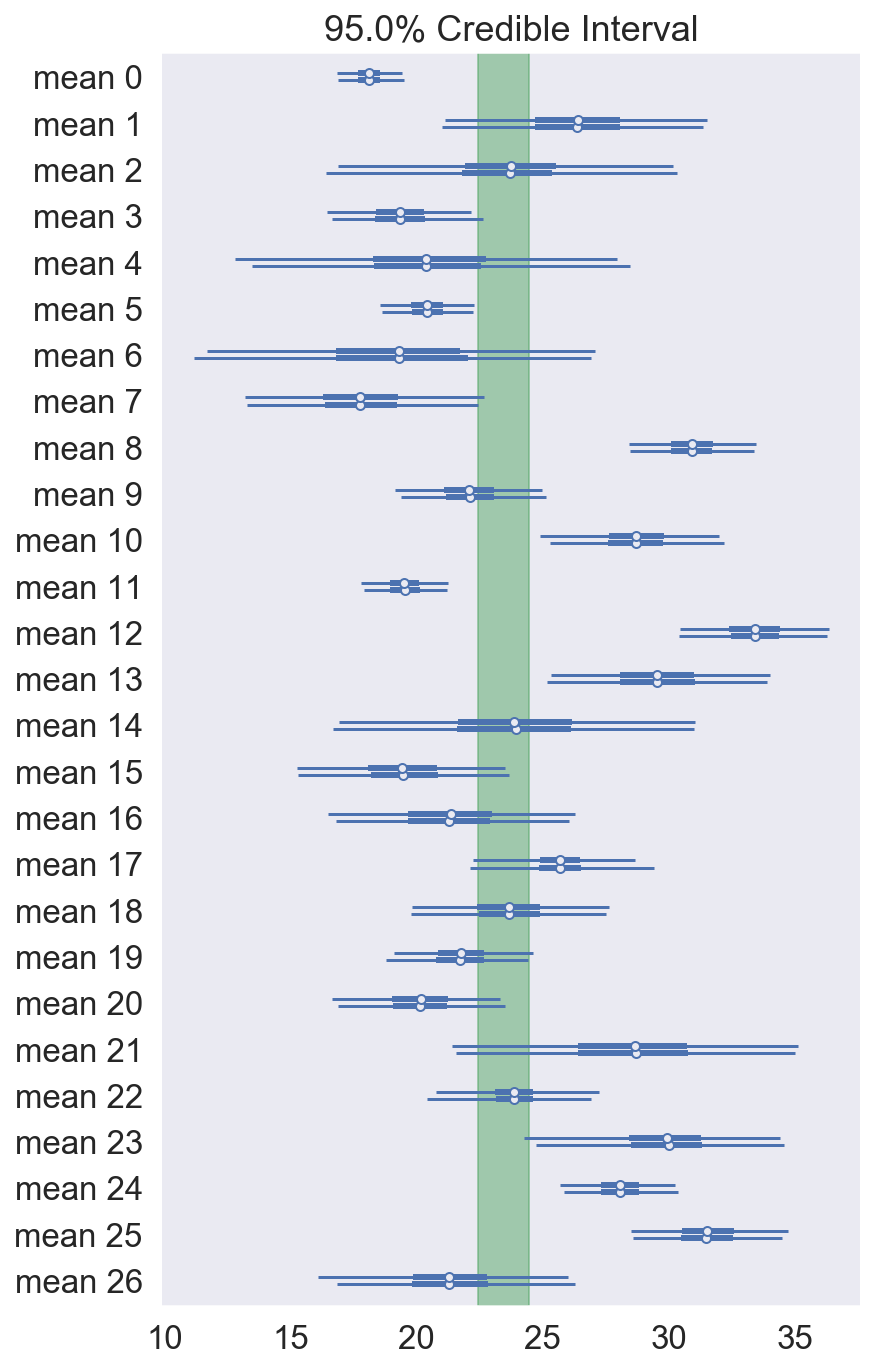

In [48]:
az.plot_forest(trace_b, credible_interval=0.95, var_names='mean', rope=rope_boundaries)
plt.show()

### Trace plot

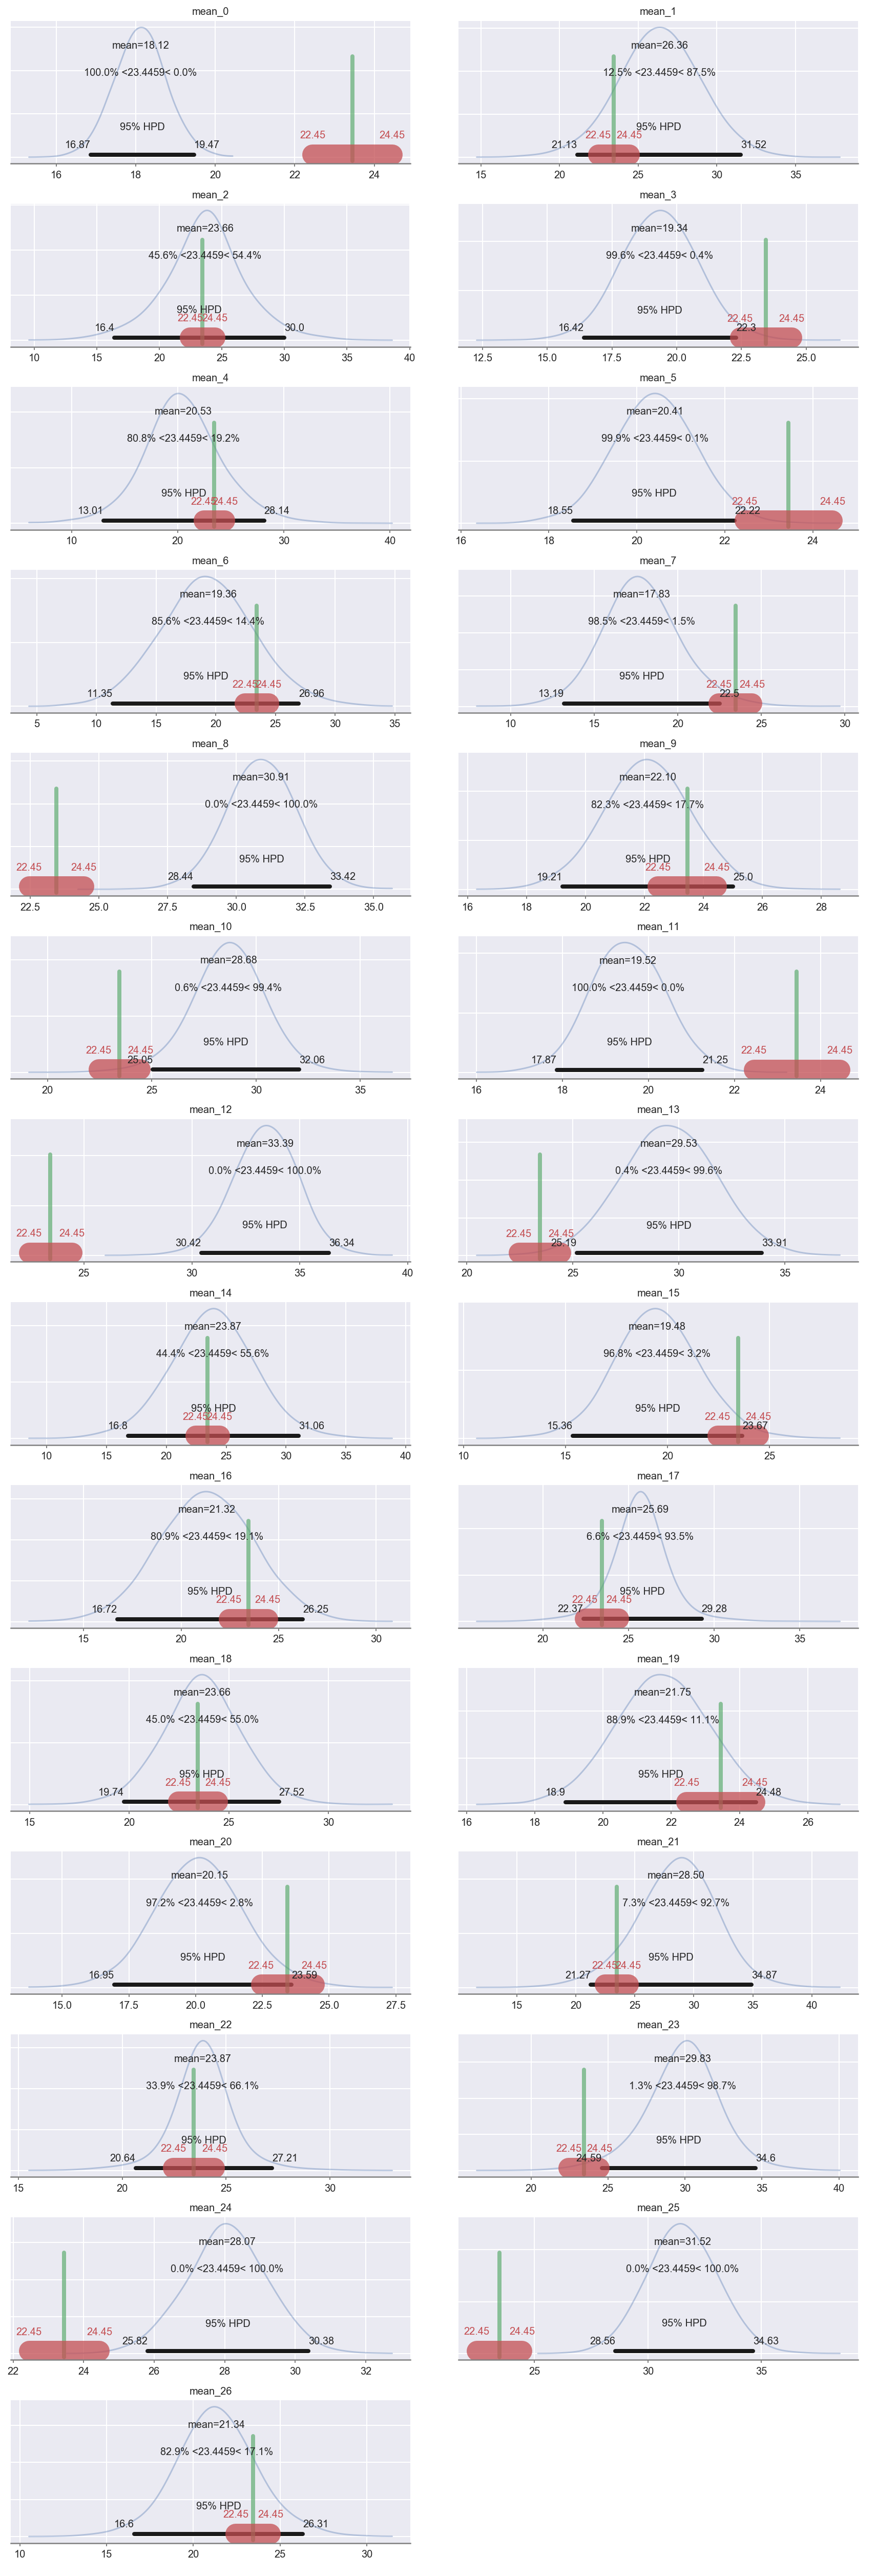

In [49]:
pm.plot_posterior(trace_b, varnames=['mean'],kde_plot=True, ref_val=df.mpg.mean(),round_to=2,rope=rope_boundaries)
plt.show()

## Hierarchical model of origin and brands

Now we construct a model where we determine the distribution of each brand influenced by the mean of each origin group itself adjusted to the mean of all observations.

In [50]:
grouped_brands = df.groupby(['origin','brand'])[['mpg']].agg([np.mean,np.std,lambda x: len(x)]).dropna()
grouped_brands

mpg                    
                        mean        std <lambda>
origin brand                                    
1      amc         18.070370   3.225358     27.0
       buick       19.182353   5.760993     17.0
       cadillac    19.750000   4.596194      2.0
       chevrolet   20.370455   6.147587     44.0
       chevy       18.000000  11.357817      3.0
       chrysler    17.266667   4.846304      6.0
       dodge       22.060714   7.574144     28.0
       ford        19.475000   5.936383     48.0
       mercury     19.118182   6.822143     11.0
       oldsmobile  21.100000   8.494181     10.0
       plymouth    21.703226   7.792367     31.0
       pontiac     20.012500   6.285632     16.0
2      audi        26.714286   6.632855      7.0
       bmw         23.750000   3.181981      2.0
       fiat        28.912500   4.102765      8.0
       mercedes    23.966667   6.863187      3.0
       opel        25.750000   1.707825      4.0
       peugeot     23.687500   4.767580      8.0
       renault     29.666667   5.507571      3.0
       saab        23.900000   1.604161      4.0
       volkswagen  31.840909   7.100480     22.0
       volvo       21.116667   5.000167      6.0
3      datsun      31.113043   5.721674     23.0
       honda       33.761538   4.764371     13.0
       mazda       30.058333   8.247144     12.0
       subaru      30.525000   3.397425      4.0
       toyota      28.165385   5.644320     26.0

Associate the origin mean with each brand name:

In [51]:
origin_means = [grouped_origin.loc[df.origin[df.brand==brand].max(),('mpg','mean')] for brand in brands]
origin_std = [grouped_origin.loc[df.origin[df.brand==brand].max(),('mpg','std')] for brand in brands]

In [52]:
brand_origin = [df.origin[df.brand==brand].max()-1 for brand in brands]

In [53]:
with pm.Model() as model_h:
    
    mean_origin = pm.Normal('mean_origin', prior_mean, sd=50, shape=len(df.origin.unique()))
    
    
    mean_brand = pm.Normal('mean_brand', [mean_origin[orig] for orig in brand_origin], sd=50, shape=len(brands))
    std_brand = pm.Uniform('std_brand', lower=prior_std_lower,upper=3*prior_std_upper, shape=len(brands))

   
    mpg = {}
    for i, brand in enumerate(brands):
        mpg[i] = pm.Normal('{}'.format(i), mu=mean_brand[i], sd=std_brand[i], 
                           observed=df.mpg[df.brand==brand].values)

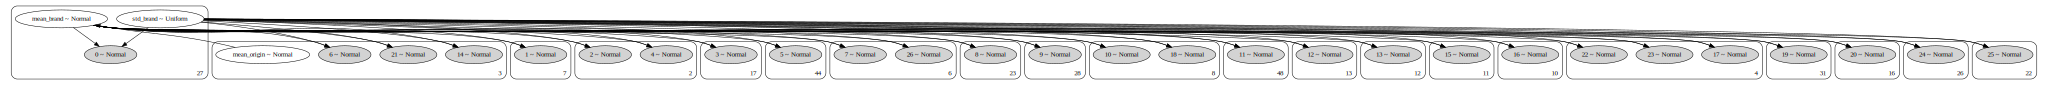

In [54]:
pm.model_to_graphviz(model_h)

In [55]:
with model_h:
    trace_h = pm.sample(5000, nuts_kwargs={'target_accept':0.95})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [std_brand, mean_brand, mean_origin]
Sampling 2 chains: 100%|██████████| 11000/11000 [02:44<00:00, 66.83draws/s]
The number of effective samples is smaller than 25% for some parameters.


In [56]:
trace_h[0]

{'mean_origin': array([38.11025715, 11.83612411, 19.17843064]),
 'mean_brand': array([17.60806045, 26.26043886, 23.64762244, 13.26631936, 30.77918834,
        21.87604688, 14.02358536, 18.074526  , 31.62943411, 21.5118076 ,
        31.46755175, 20.51217389, 30.77408962, 26.79010898, 34.52253322,
        21.78127278, 26.14535791, 34.62402415, 24.01213927, 22.68728641,
        20.07066527, 32.27058139, 23.95947884, 30.0074761 , 26.76581052,
        31.14961617, 23.33405214]),
 'std_brand_interval__': array([-2.02299746, -1.66148218, -2.80396893, -0.88890102, -0.38568714,
        -1.34735516,  2.87244773, -0.90031705, -1.52406094, -1.05760381,
        -1.70880095, -1.34912504, -1.29453067, -0.68049238, -0.95259487,
        -1.26711349, -0.53908884,  0.48275155, -1.63247547, -1.16630831,
        -1.39399426, -1.70096408, -2.28882621, -2.14671306, -1.04185163,
        -1.54376645, -1.23289874]),
 'std_brand': array([ 3.50429093,  4.78690239,  1.71331179,  8.7401072 , 12.14268483,
         6

### Forest plot

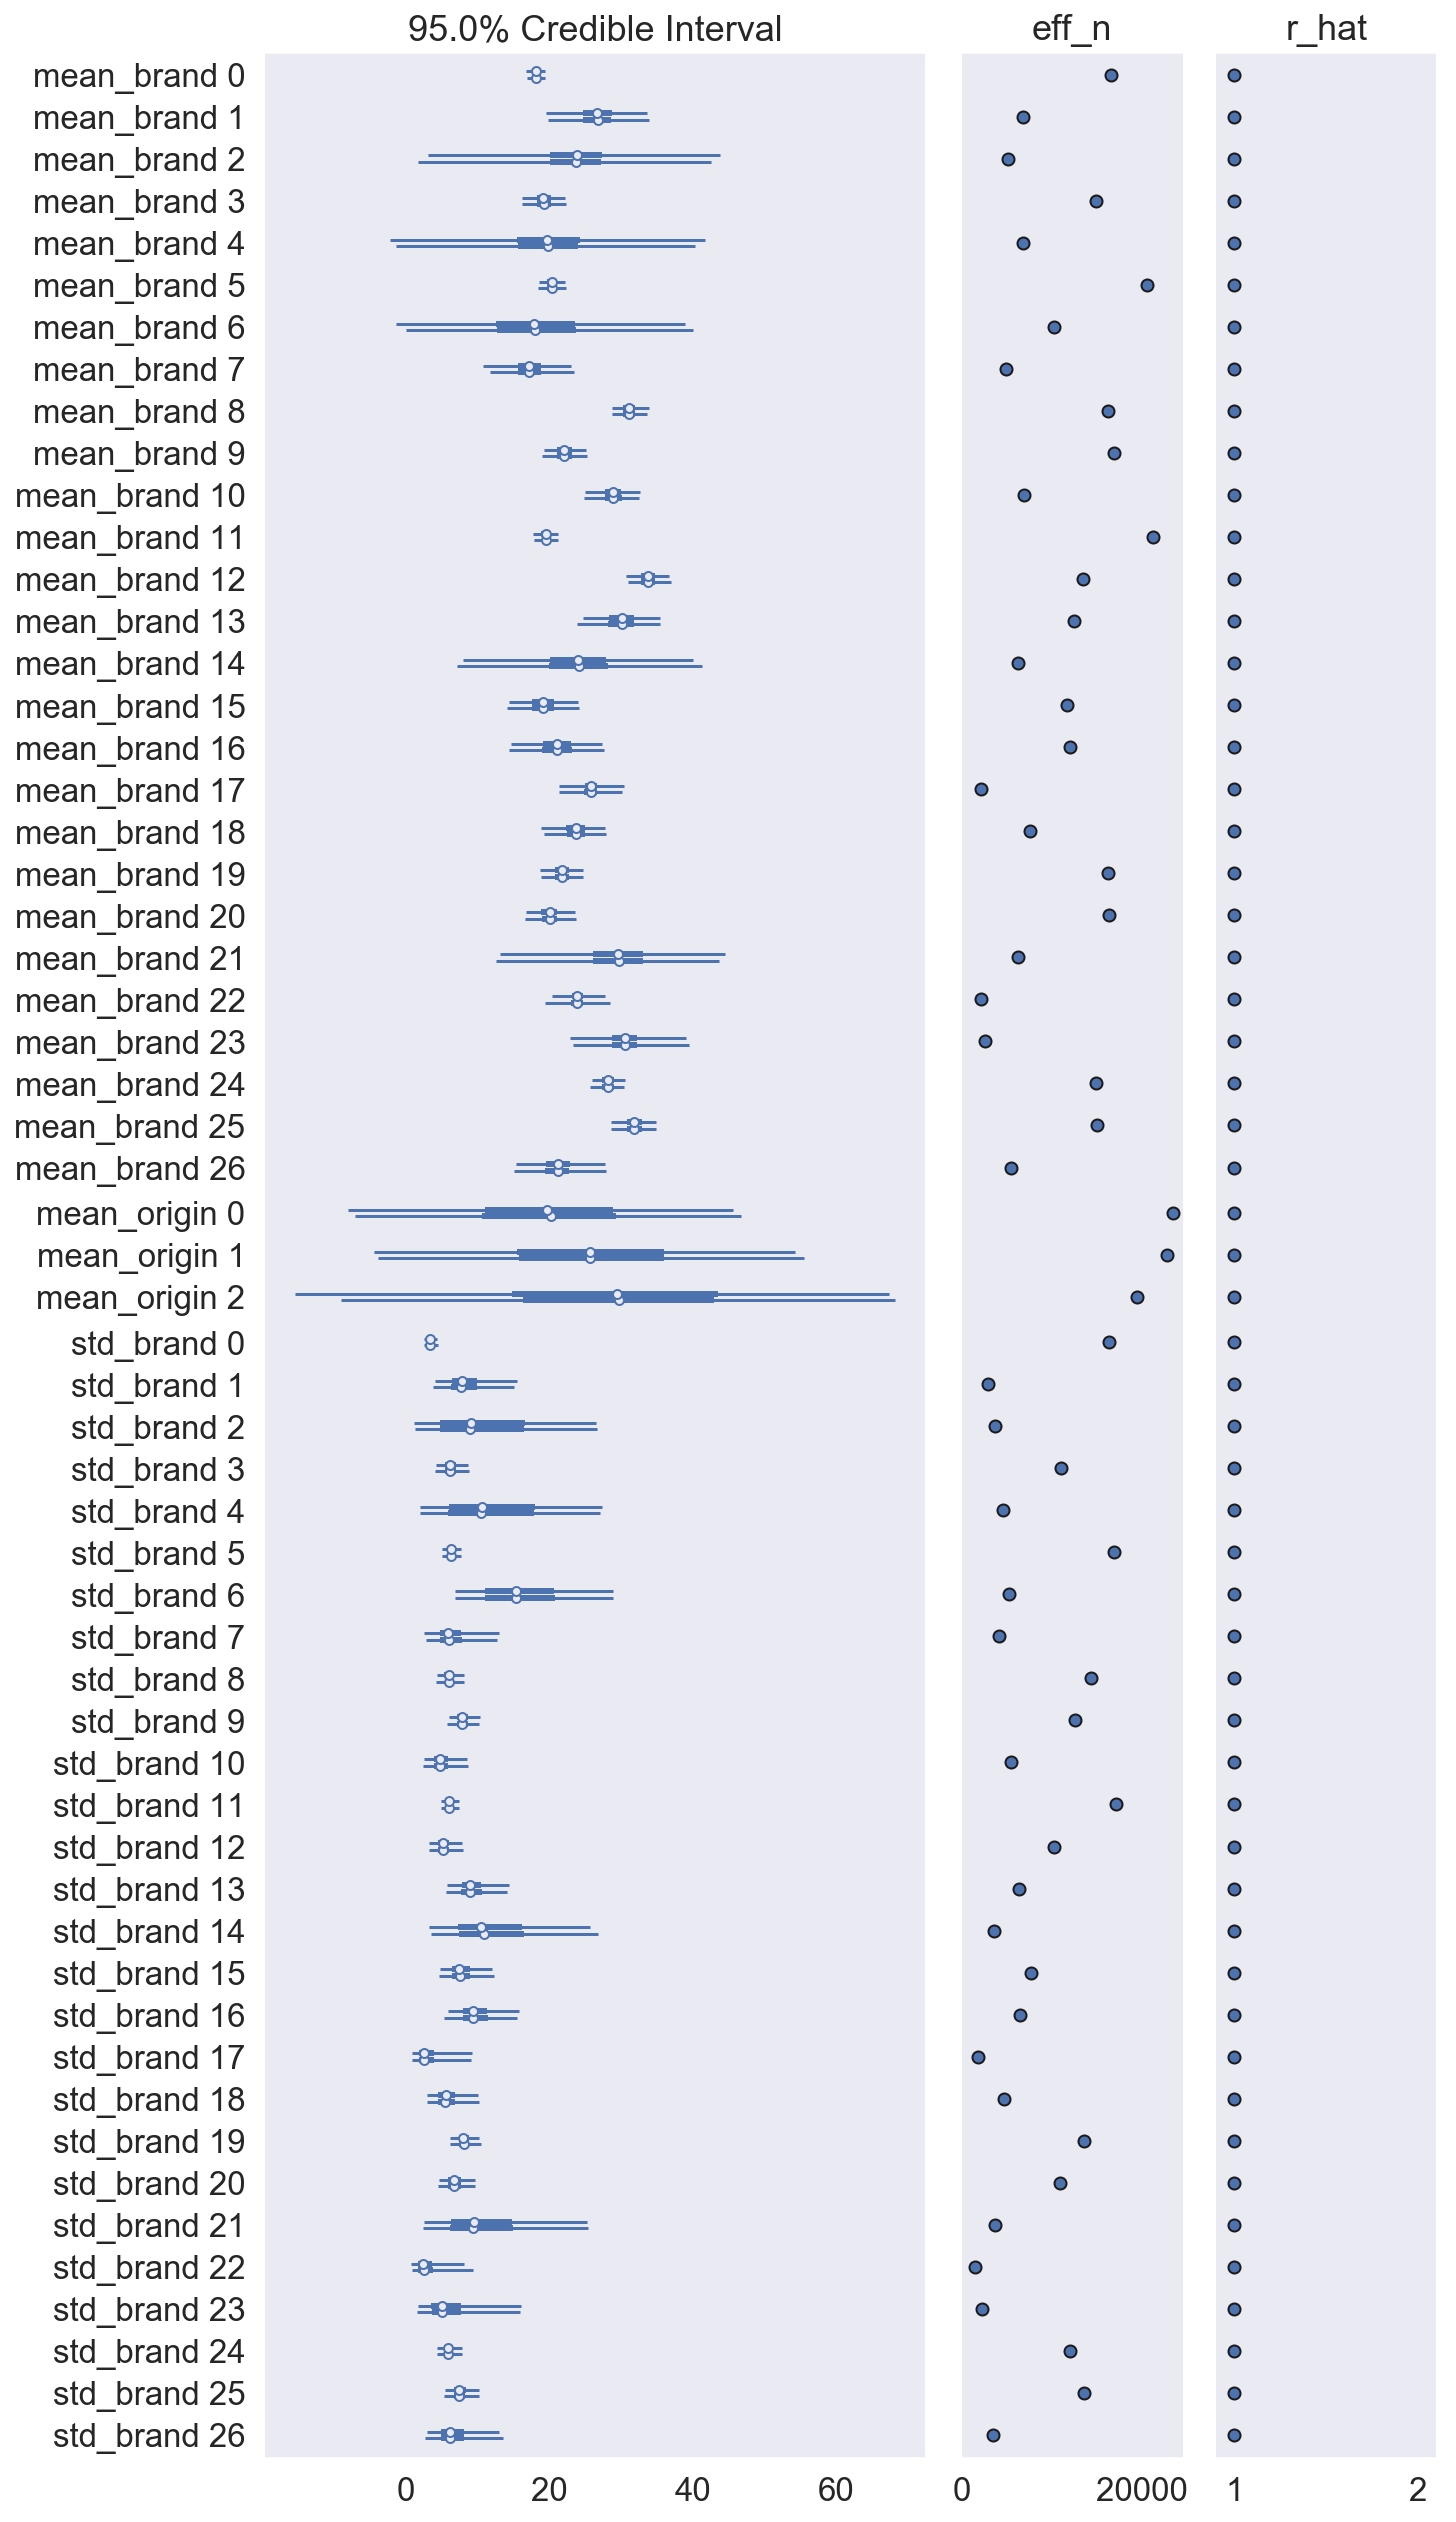

In [57]:
az.plot_forest(trace_h,credible_interval=0.95, eff_n=True, r_hat=True)
plt.show()

### Trace plot

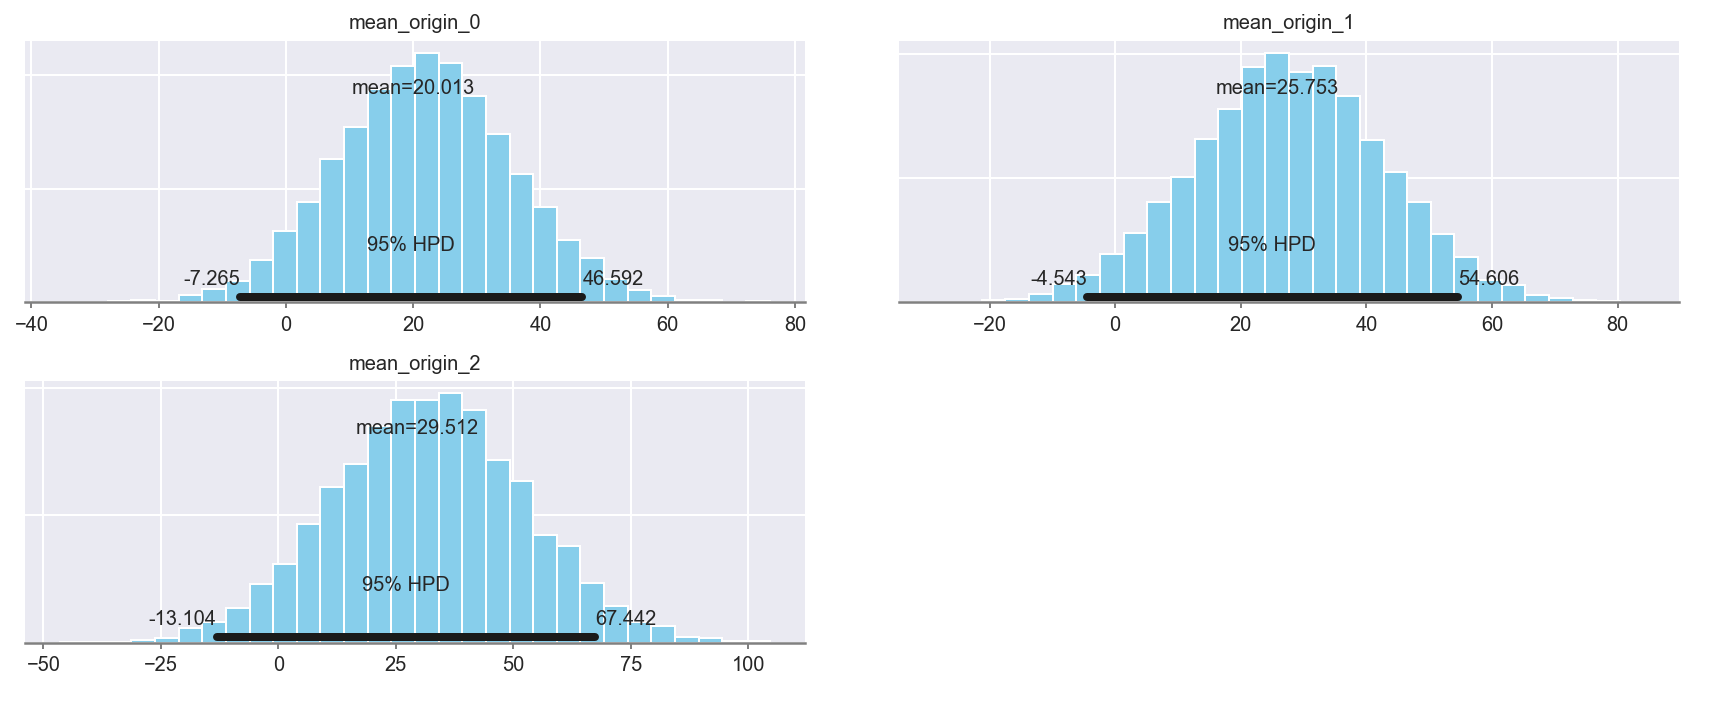

In [58]:
pm.plot_posterior(trace_h, varnames=['mean_origin'])
plt.show()

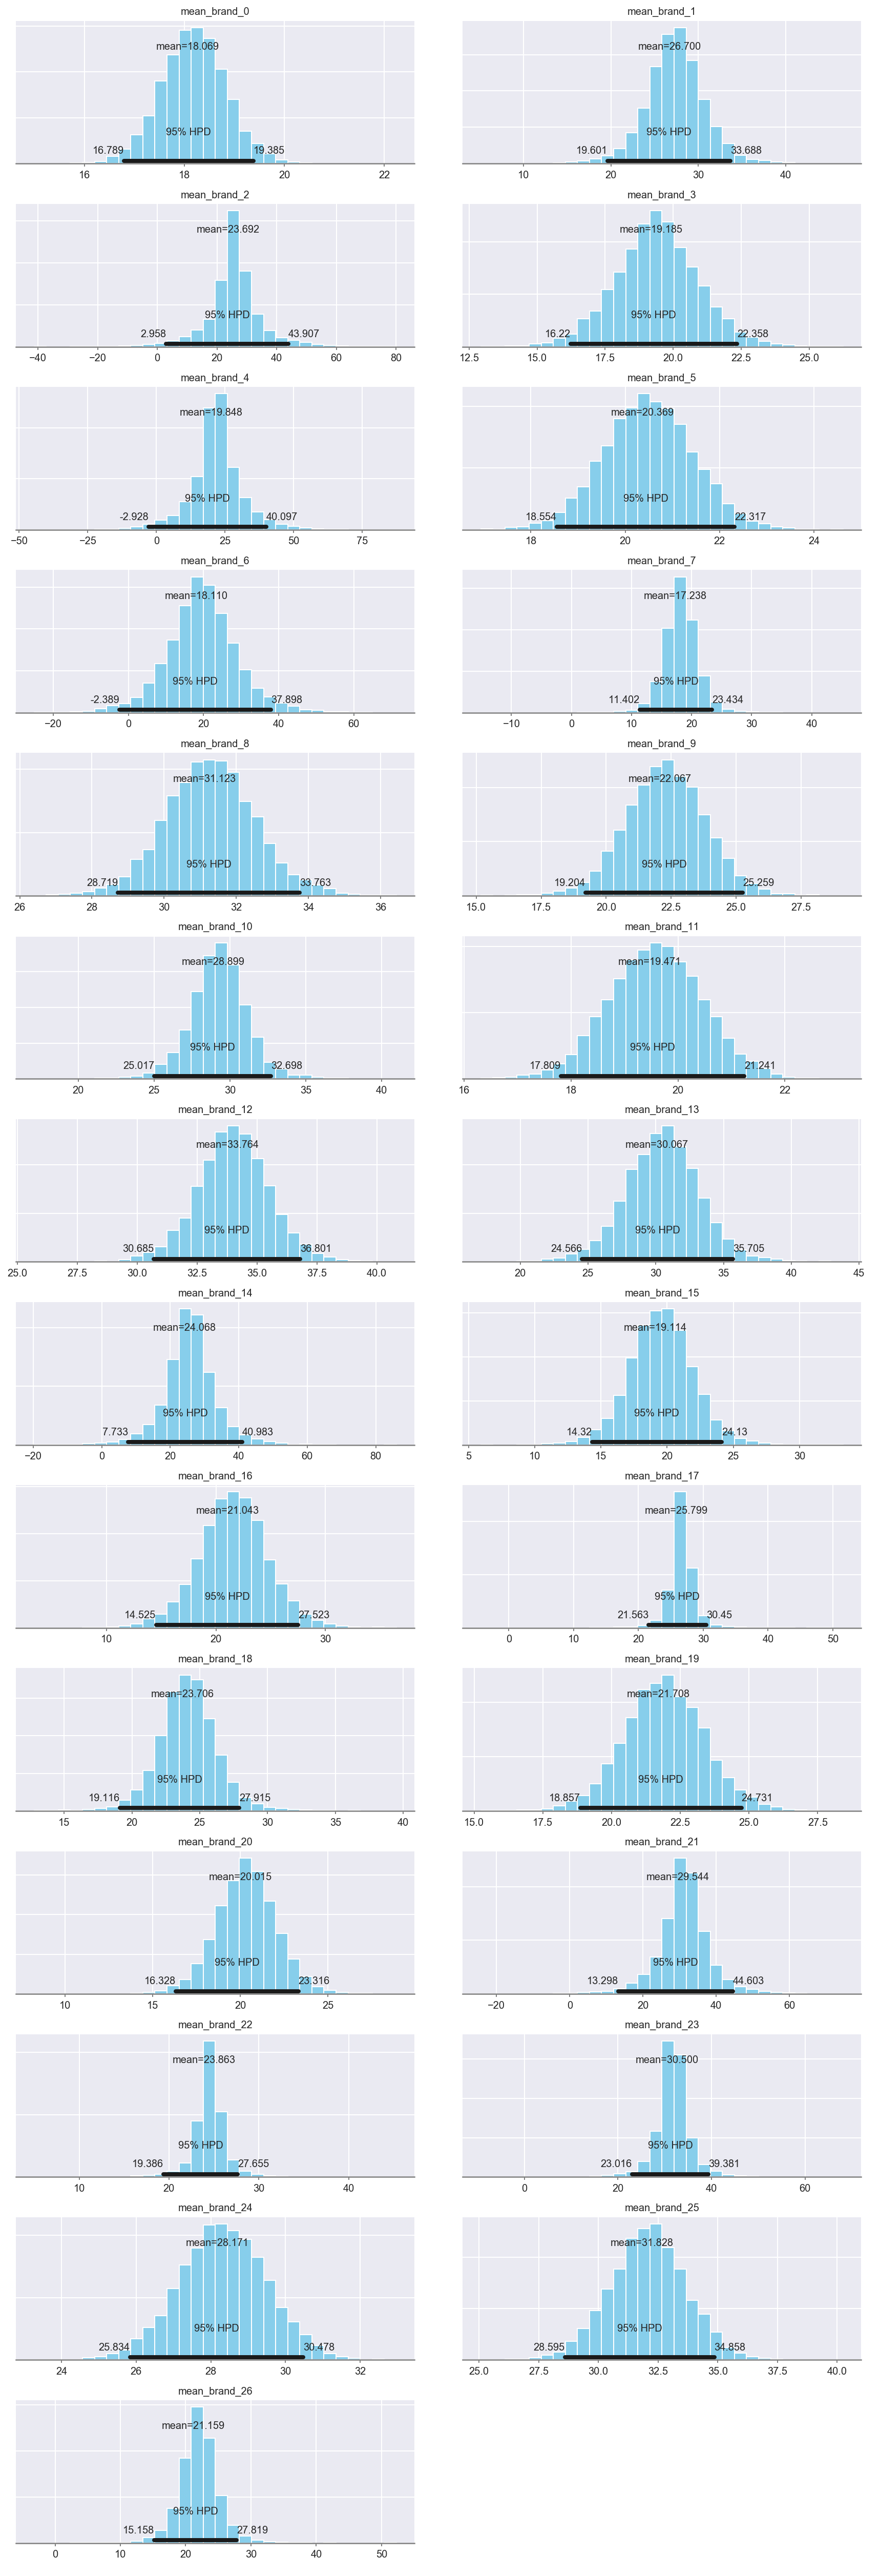

In [59]:
pm.plot_posterior(trace_h, varnames=['mean_brand'])
plt.show()

### Model summary

In [60]:
summary_h = pm.summary(trace_h)
summary_h

mean         sd  mc_error    hpd_2.5   hpd_97.5  \
mean_origin__0  20.012751  13.780509  0.095267  -7.265120  46.591784   
mean_origin__1  25.753368  15.230052  0.105387  -4.542722  54.605956   
mean_origin__2  29.511646  20.529331  0.154869 -13.103909  67.442258   
mean_brand__0   18.068967   0.655325  0.004664  16.789388  19.384724   
mean_brand__1   26.699966   3.495952  0.043101  19.601179  33.688360   
mean_brand__2   23.692031   9.221956  0.124334   2.958096  43.907471   
mean_brand__3   19.185139   1.549408  0.012529  16.220465  22.358363   
mean_brand__4   19.848397   9.812882  0.131517  -2.927755  40.096911   
mean_brand__5   20.369257   0.962257  0.006974  18.553636  22.317007   
mean_brand__6   18.109861   9.702979  0.105203  -2.389408  37.898498   
mean_brand__7   17.237698   3.093235  0.045227  11.401643  23.433789   
mean_brand__8   31.123225   1.265436  0.008577  28.718763  33.762770   
mean_brand__9   22.067356   1.550157  0.010937  19.204096  25.259410   
mean_brand__10  28.899391   1.927761  0.022283  25.016738  32.697696   
mean_brand__11  19.470933   0.877312  0.005841  17.809035  21.241470   
mean_brand__12  33.763634   1.530688  0.013490  30.685010  36.800993   
mean_brand__13  30.067224   2.802485  0.029274  24.565657  35.704634   
mean_brand__14  24.067724   7.877206  0.098048   7.732505  40.982937   
mean_brand__15  19.114237   2.467741  0.021412  14.319801  24.129584   
mean_brand__16  21.042836   3.241426  0.029509  14.524674  27.523408   
mean_brand__17  25.798812   2.498720  0.056005  21.562767  30.450155   
mean_brand__18  23.705810   2.218845  0.023617  19.116118  27.915155   
mean_brand__19  21.707689   1.477295  0.011438  18.856880  24.731368   
mean_brand__20  20.015015   1.743972  0.014252  16.327866  23.315821   
mean_brand__21  29.543605   7.444763  0.106649  13.297700  44.602674   
mean_brand__22  23.862807   2.074915  0.042984  19.385772  27.654743   
mean_brand__23  30.499976   4.052260  0.075620  23.015724  39.381201   
mean_brand__24  28.171177   1.184103  0.009935  25.833631  30.478484   
mean_brand__25  31.828180   1.610331  0.011367  28.594523  34.857948   
mean_brand__26  21.159483   3.169981  0.044600  15.157948  27.819173   
std_brand__0     3.385733   0.499043  0.003720   2.539971   4.450932   
std_brand__1     8.565524   3.373812  0.065075   3.964177  15.329309   
std_brand__2    11.204751   7.715177  0.125223   1.217138  26.653586   
std_brand__3     6.280468   1.238769  0.011643   4.080435   8.700308   
std_brand__4    12.354725   7.558895  0.109242   1.800706  27.095759   
std_brand__5     6.337158   0.705869  0.005444   5.050549   7.751487   
std_brand__6    16.135436   6.269970  0.094270   6.781337  28.859963   
std_brand__7     6.708016   3.090711  0.049727   2.600871  12.794693   
std_brand__8     6.086599   1.018717  0.008841   4.234626   8.076473   
std_brand__9     7.968870   1.161430  0.009825   5.847611  10.236131   
std_brand__10    5.091922   1.797335  0.022971   2.502152   8.573161   
std_brand__11    6.097190   0.642357  0.005419   4.930316   7.407736   
std_brand__12    5.364190   1.284758  0.011771   3.187172   7.842586   
std_brand__13    9.409582   2.466019  0.031230   5.518308  14.154194   
std_brand__14   12.439160   6.511246  0.111467   3.512813  26.336739   
std_brand__15    7.860113   2.119934  0.023130   4.572340  12.093111   
std_brand__16    9.929720   2.802962  0.029816   5.410695  15.513086   
std_brand__17    3.500898   3.239946  0.070628   0.797130   9.121195   
std_brand__18    5.947018   2.176969  0.032283   2.862537  10.152933   
std_brand__19    8.132798   1.102732  0.009710   6.103198  10.280343   
std_brand__20    6.864357   1.391054  0.011776   4.501617   9.591087   
std_brand__21   11.248769   6.534695  0.122448   2.425462  25.266572   
std_brand__22    3.290539   3.014573  0.073512   0.753604   8.539245   
std_brand__23    6.438783   4.473493  0.089329   1.503215  15.974985   
std_brand__24    5.954250   0.924859  0.007957   4.290190   7

In [61]:
summary_h.loc[:'mean_brand__26']

mean         sd  mc_error    hpd_2.5   hpd_97.5  \
mean_origin__0  20.012751  13.780509  0.095267  -7.265120  46.591784   
mean_origin__1  25.753368  15.230052  0.105387  -4.542722  54.605956   
mean_origin__2  29.511646  20.529331  0.154869 -13.103909  67.442258   
mean_brand__0   18.068967   0.655325  0.004664  16.789388  19.384724   
mean_brand__1   26.699966   3.495952  0.043101  19.601179  33.688360   
mean_brand__2   23.692031   9.221956  0.124334   2.958096  43.907471   
mean_brand__3   19.185139   1.549408  0.012529  16.220465  22.358363   
mean_brand__4   19.848397   9.812882  0.131517  -2.927755  40.096911   
mean_brand__5   20.369257   0.962257  0.006974  18.553636  22.317007   
mean_brand__6   18.109861   9.702979  0.105203  -2.389408  37.898498   
mean_brand__7   17.237698   3.093235  0.045227  11.401643  23.433789   
mean_brand__8   31.123225   1.265436  0.008577  28.718763  33.762770   
mean_brand__9   22.067356   1.550157  0.010937  19.204096  25.259410   
mean_brand__10  28.899391   1.927761  0.022283  25.016738  32.697696   
mean_brand__11  19.470933   0.877312  0.005841  17.809035  21.241470   
mean_brand__12  33.763634   1.530688  0.013490  30.685010  36.800993   
mean_brand__13  30.067224   2.802485  0.029274  24.565657  35.704634   
mean_brand__14  24.067724   7.877206  0.098048   7.732505  40.982937   
mean_brand__15  19.114237   2.467741  0.021412  14.319801  24.129584   
mean_brand__16  21.042836   3.241426  0.029509  14.524674  27.523408   
mean_brand__17  25.798812   2.498720  0.056005  21.562767  30.450155   
mean_brand__18  23.705810   2.218845  0.023617  19.116118  27.915155   
mean_brand__19  21.707689   1.477295  0.011438  18.856880  24.731368   
mean_brand__20  20.015015   1.743972  0.014252  16.327866  23.315821   
mean_brand__21  29.543605   7.444763  0.106649  13.297700  44.602674   
mean_brand__22  23.862807   2.074915  0.042984  19.385772  27.654743   
mean_brand__23  30.499976   4.052260  0.075620  23.015724  39.381201   
mean_brand__24  28.171177   1.184103  0.009935  25.833631  30.478484   
mean_brand__25  31.828180   1.610331  0.011367  28.594523  34.857948   
mean_brand__26  21.159483   3.169981  0.044600  15.157948  27.819173   

                       n_eff      Rhat  
mean_origin__0  23376.523416  0.999914  
mean_origin__1  22699.439177  0.999904  
mean_origin__2  19379.459392  0.999935  
mean_brand__0   16479.249419  0.999941  
mean_brand__1    6745.327352  0.999991  
mean_brand__2    5060.700841  0.999941  
mean_brand__3   14810.065629  0.999900  
mean_brand__4    6740.307424  0.999901  
mean_brand__5   20519.352280  0.999907  
mean_brand__6   10161.782372  1.000093  
mean_brand__7    4833.197020  1.000069  
mean_brand__8   16180.578474  0.999919  
mean_brand__9   16901.101253  0.999948  
mean_brand__10   6915.316420  0.999900  
mean_brand__11  21222.934581  0.999994  
mean_brand__12  13436.878849  1.000116  
mean_brand__13  12466.718223  1.000009  
mean_brand__14   6161.950246  0.999957  
mean_brand__15  11588.210324  0.999900  
mean_brand__16  11972.166281  0.999924  
mean_brand__17   2048.947132  1.000121  
mean_brand__18   7507.139431  0.999938  
mean_brand__19  16251.789927  0.999902  
mean_brand__20  16276.073309  0.999909  
mean_brand__21   6172.221673  0.999914  
mean_brand__22   2109.027407  1.000717  
mean_brand__23   2517.043734  0.999929  
mean_brand__24  14890.514084  0.999966  
mean_brand__25  15026.384410  0.999946  
mean_brand__26   5461.349671  0.999936

### Adjusted means

In [62]:
pd.DataFrame({'brands':summary_h.loc['mean_brand__0':'mean_brand__26','mean'].values,
              'origin':np.array(origin_means),
              'overall':[prior_mean]*len(brands)},index=brands).T

brand          amc       audi        bmw      buick   cadillac  chevrolet  \
brands   18.068967  26.699966  23.692031  19.185139  19.848397  20.369257   
origin   20.033469  27.602941  27.602941  20.033469  20.033469  20.033469   
overall  23.445918  23.445918  23.445918  23.445918  23.445918  23.445918   

brand        chevy   chrysler     datsun      dodge    ...           opel  \
brands   18.109861  17.237698  31.123225  22.067356    ...      25.798812   
origin   20.033469  20.033469  30.450633  20.033469    ...      27.602941   
overall  23.445918  23.445918  23.445918  23.445918    ...      23.445918   

brand      peugeot   plymouth    pontiac    renault       saab     subaru  \
brands   23.705810  21.707689  20.015015  29.543605  23.862807  30.499976   
origin   27.602941  20.033469  20.033469  27.602941  27.602941  30.450633   
overall  23.445918  23.445918  23.445918  23.445918  23.445918  23.445918   

brand       toyota  volkswagen      volvo  
brands   28.171177   31.828180  21.159483  
origin   30.450633   27.602941  27.602941  
overall  23.445918   23.445918  23.445918  

[3 rows x 27 columns]

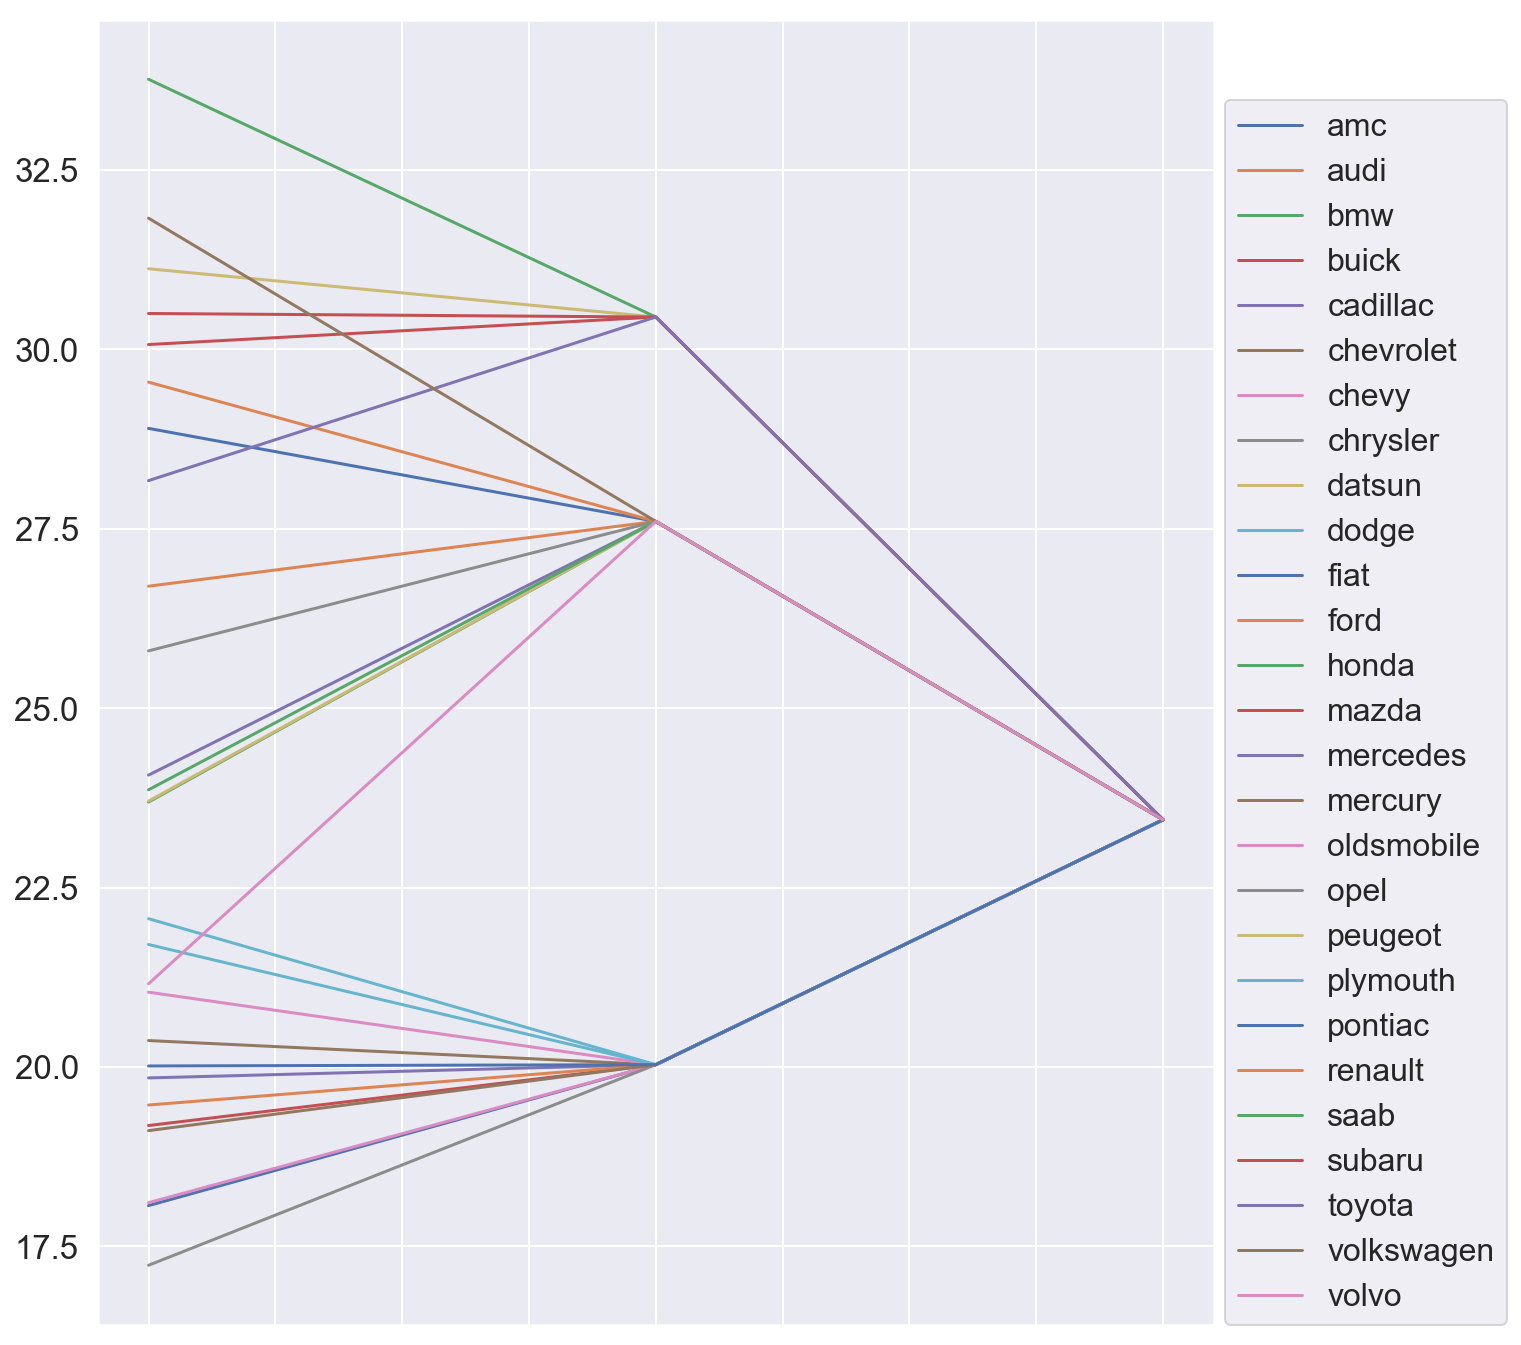

In [63]:
pd.DataFrame({'brands':summary_h.loc['mean_brand__0':'mean_brand__26','mean'].values,
              'origin':np.array(origin_means),
              'overall':[prior_mean]*len(brands)},
              index=brands).T.plot(figsize=(10,12))
plt.legend(loc=[1.01,0],fontsize=16)
plt.show()

In [64]:
mean_adjustment = grouped_brands.reset_index().iloc[:,1:3].sort_values(by='brand').reset_index(drop=True)
mean_adjustment['hierarchical'] = summary_h.loc['mean_brand__0':'mean_brand__26','mean'].values
mean_adjustment

brand        mpg hierarchical
                     mean             
0          amc  18.070370    18.068967
1         audi  26.714286    26.699966
2          bmw  23.750000    23.692031
3        buick  19.182353    19.185139
4     cadillac  19.750000    19.848397
5    chevrolet  20.370455    20.369257
6        chevy  18.000000    18.109861
7     chrysler  17.266667    17.237698
8       datsun  31.113043    31.123225
9        dodge  22.060714    22.067356
10        fiat  28.912500    28.899391
11        ford  19.475000    19.470933
12       honda  33.761538    33.763634
13       mazda  30.058333    30.067224
14    mercedes  23.966667    24.067724
15     mercury  19.118182    19.114237
16  oldsmobile  21.100000    21.042836
17        opel  25.750000    25.798812
18     peugeot  23.687500    23.705810
19    plymouth  21.703226    21.707689
20     pontiac  20.012500    20.015015
21     renault  29.666667    29.543605
22        saab  23.900000    23.862807
23      subaru  30.525000    30.499976
24      toyota  28.165385    28.171177
25  volkswagen  31.840909    31.828180
26       volvo  21.116667    21.159483

## Robust model

In [65]:
with pm.Model() as model_v1:
    
    mean = pm.Normal('mean', mu=prior_mean, sd=prior_mean_std, shape=n_groups)
    std = pm.Gamma('precision', mu=5, sd=10, shape=n_groups)
    nu_minus1 = pm.Exponential('nu_minus1', 1/29)
    nu = pm.Deterministic('nu', nu_minus1+1)
    
    mpg = {}
    
    for i, observed in enumerate(mpg_values):
        mpg[i] = pm.StudentT('{}'.format(i), nu=nu, mu=mean[i], sd=std[i], observed=mpg_values[i])

    mean_delta = {}
    std_delta = {}
    
    for i,j in combinations(range(n_groups),2):
        mean_delta[(i,j)] = pm.Deterministic('delta_mean_{}'.format((i,j)), mean[i]-mean[j])
        std_delta[(i,j)] = pm.Deterministic('delta_std_{}'.format((i,j)), std[i]-std[j])

In [66]:
with pm.Model() as model_hi:
    
    mean_origin = pm.Normal('mean_origin', prior_mean, sd=50, shape=n_groups)
    std_origin = pm.Gamma('std_origin', mu=5, sd=10, shape=n_groups)
    
    mean_brand = pm.Normal('mean_brand', [mean_origin[orig] for orig in brand_origin], sd=50, shape=len(brands))
    std_brand = pm.Gamma('std_brand', mu=5, sd=10, shape=len(brands))

    nu_minus1 = pm.Exponential('nu_minus1', 1/29)
    nu = pm.Deterministic('nu', nu_minus1+1)
   
    mpg = {}
    for i, brand in enumerate(brands):
        mpg[i] = pm.StudentT('{}'.format(i), nu=nu, mu=mean_brand[i], sd=std_brand[i], 
                           observed=df.mpg[df.brand==brand].values)

In [67]:
with model_hi:
    trace_hi = pm.sample(5000, nuts_kwargs={'target_accept':0.95}, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu_minus1, std_brand, mean_brand, std_origin, mean_origin]
Sampling 2 chains: 100%|██████████| 12000/12000 [04:14<00:00, 47.17draws/s]
The number of effective samples is smaller than 25% for some parameters.


### Forest plot

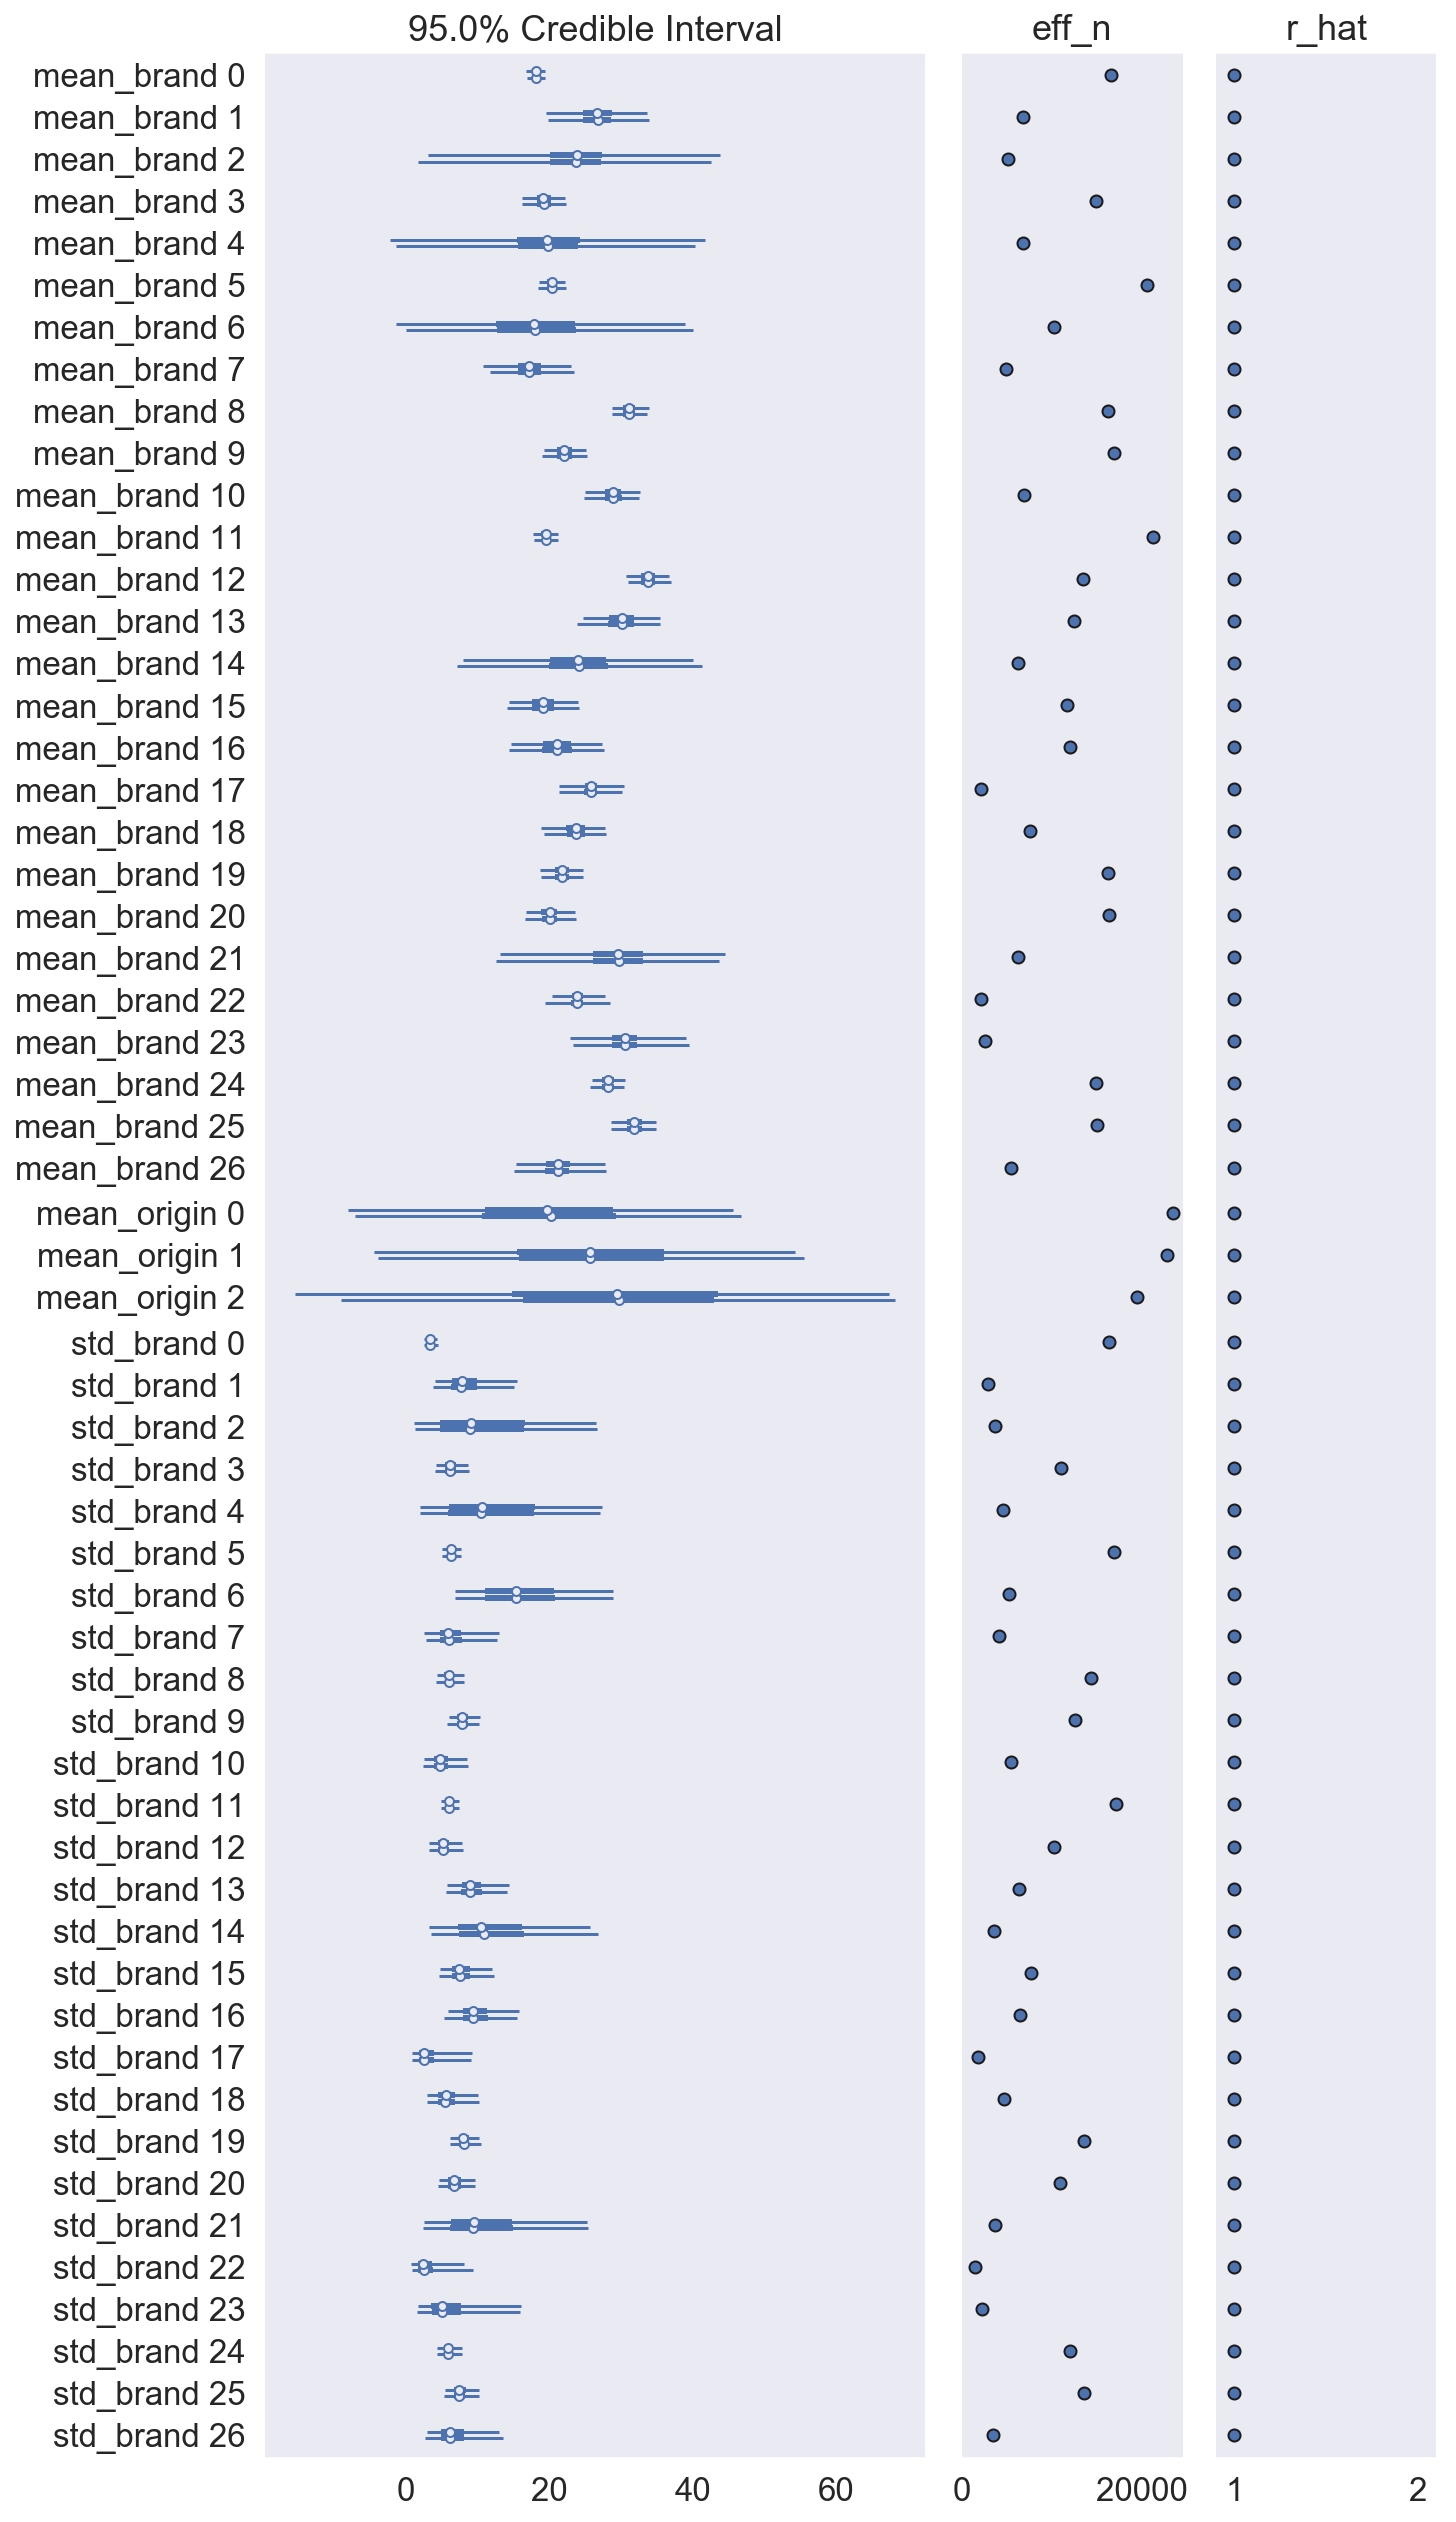

In [68]:
az.plot_forest(trace_h,credible_interval=0.95, eff_n=True, r_hat=True)
plt.show()

### Summary

In [69]:
pm.summary(trace_hi)

mean         sd  mc_error       hpd_2.5    hpd_97.5  \
mean_origin__0  19.812838  13.672216  0.092613 -6.405044e+00   47.163128   
mean_origin__1  25.710960  15.364065  0.099836 -4.390475e+00   55.394399   
mean_origin__2  29.336667  20.433344  0.130776 -1.021537e+01   69.107100   
mean_brand__0   17.992242   0.641174  0.004872  1.676283e+01   19.301456   
mean_brand__1   26.636189   2.950419  0.026673  2.062015e+01   32.359800   
mean_brand__2   23.848321   5.772315  0.102299  1.231044e+01   35.506115   
mean_brand__3   19.104427   1.486163  0.011137  1.639126e+01   22.259571   
mean_brand__4   19.606995   7.509949  0.144089  3.901829e+00   33.943702   
mean_brand__5   20.253021   0.962112  0.006387  1.834598e+01   22.112611   
mean_brand__6   17.969203   8.597599  0.106474  1.082413e+00   36.433952   
mean_brand__7   17.136687   2.457419  0.030910  1.233901e+01   22.269136   
mean_brand__8   31.131547   1.282252  0.008626  2.855180e+01   33.586028   
mean_brand__9   21.968020   1.509854  0.009931  1.902876e+01   25.031106   
mean_brand__10  28.809834   1.663096  0.016697  2.542696e+01   32.048091   
mean_brand__11  19.336306   0.880328  0.006196  1.763372e+01   21.045064   
mean_brand__12  33.727552   1.403352  0.012478  3.093960e+01   36.449062   
mean_brand__13  30.019234   2.617397  0.020254  2.463019e+01   34.982438   
mean_brand__14  23.991783   6.072374  0.098750  1.196497e+01   35.938175   
mean_brand__15  18.872402   2.205759  0.019738  1.459547e+01   23.262043   
mean_brand__16  20.983498   2.991423  0.025854  1.496868e+01   27.011435   
mean_brand__17  25.755619   1.427094  0.022155  2.314164e+01   28.493151   
mean_brand__18  23.732065   1.963636  0.020071  1.969108e+01   27.532039   
mean_brand__19  21.469315   1.435552  0.010644  1.861277e+01   24.267463   
mean_brand__20  19.849255   1.708360  0.012840  1.647605e+01   23.188443   
mean_brand__21  29.531851   5.410910  0.068801  1.809407e+01   40.075302   
mean_brand__22  23.941860   1.352477  0.027136  2.155527e+01   26.553148   
mean_brand__23  30.520592   2.573983  0.035078  2.537737e+01   35.413151   
mean_brand__24  28.118427   1.178096  0.008665  2.574838e+01   30.456997   
mean_brand__25  31.673090   1.618241  0.012122  2.851152e+01   34.850994   
mean_brand__26  20.906730   2.523760  0.027140  1.606370e+01   25.948084   
...                   ...        ...       ...           ...         ...   
std_origin__2    5.027966  10.033149  0.107638  9.954385e-15   24.132126   
std_brand__0     3.159338   0.495623  0.004208  2.305984e+00    4.169179   
std_brand__1     7.375081   2.525459  0.031433  3.555145e+00   12.156033   
std_brand__2     6.182635   6.437959  0.100098  8.278530e-01   17.820999   
std_brand__3     5.911065   1.166744  0.010955  3.953008e+00    8.280983   
std_brand__4     7.984906   7.375400  0.134823  1.281591e+00   22.129529   
std_brand__5     6.124955   0.707958  0.005621  4.871069e+00    7.602655   
std_brand__6    13.473779   7.671127  0.099651  4.212765e+00   28.169494   
std_brand__7     5.486465   2.228037  0.025481  2.223194e+00    9.692553   
std_brand__8     5.818327   0.939897  0.007200  4.095665e+00    7.671242   
std_brand__9     7.658856   1.119900  0.008694  5.663175e+00    9.894816   
std_brand__10    4.409919   1.423186  0.014410  2.193179e+00    7.258814   
std_brand__11    5.817670   0.645611  0.004644  4.590228e+00    7.075148   
std_brand__12    4.801061   1.123815  0.009859  2.817207e+00    6.983779   
std_brand__13    8.518501   2.021285  0.017715  5.140398e+00   12.605433   
std_brand__14    8.999365   5.683317  0.086966  2.410807e+00   20.077696   
std_brand__15    6.901595   1.856052  0.016898  3.988787e+00   10.616591   
std_brand__16    8.893150   2.419816  0.023149  4.922961e+00   13.640372   
std_brand__17    2.351553   1.654224  0.029042  6.741060e-01    4.966829   
std_brand__18    5.240473   1.673158  0.018342  2.720891e+00    8.639914   
std_brand__19    7.728434   1.092581  0.008633  5.713732e+00    9.919